In [4]:
import numpy as np
from scipy.optimize import minimize
from scipy.linalg import solve

def quadratic_model(Y, f_values):
    # Ensure sufficient interpolation points
    q = len(Y)
    n = len(Y[0])
    required_points = (n + 1) * (n + 2) // 2
    if q < required_points:
        raise ValueError(f"Not enough interpolation points. Need at least {required_points}, but got {q}.")

    # Fit a quadratic model to the interpolation points Y and their function values f_values
    A = np.zeros((q, required_points))
    
    for i in range(q):
        row = [1] + list(Y[i]) + [Y[i][j] * Y[i][k] for j in range(n) for k in range(j, n)]
        A[i, :] = row
    
    coefs = solve(A, f_values)
    return coefs

def model_value(coefs, x):
    n = len(x)
    terms = [1] + list(x) + [x[j] * x[k] for j in range(n) for k in range(j, n)]
    return np.dot(coefs, terms)

def trust_region_subproblem(coefs, xk, delta):
    def model_p(p):
        return model_value(coefs, xk + p)
    
    bounds = [(-delta, delta)] * len(xk)
    res = minimize(model_p, np.zeros_like(xk), bounds=bounds)
    return res.x

def compute_rho(f, xk, pk, mk, f_values, coefs):
    actual_reduction = f(xk) - f(xk + pk)
    predicted_reduction = mk - model_value(coefs, xk + pk)
    return actual_reduction / predicted_reduction if predicted_reduction != 0 else 0

def geometry_improving_procedure(Y):
    # Simple example: just perturb one point slightly
    perturbed_Y = Y.copy()
    perturbed_Y[0] = Y[0] + 0.1 * np.random.randn(*Y[0].shape)
    return perturbed_Y

def condition_to_check_Y(Y):
    # Check if points in Y are too close to each other
    n = len(Y)
    distances = [np.linalg.norm(Y[i] - Y[j]) for i in range(n) for j in range(i + 1, n)]
    return np.min(distances) < 1e-3

def derivative_free_optimization(f, Y, delta0, eta, max_iter=100):
    # Initialization
    xk = min(Y, key=f)
    delta = delta0
    k = 0
    f_values = np.array([f(y) for y in Y])
    
    while k < max_iter:
        # Form quadratic model
        coefs = quadratic_model(Y, f_values)
        mk = model_value(coefs, xk)
        
        # Compute step p
        pk = trust_region_subproblem(coefs, xk, delta)
        xk_plus = xk + pk
        
        # Compute ratio ρ
        rho = compute_rho(f, xk, pk, mk, f_values, coefs)
        
        if rho >= eta:
            # Replace an element of Y by xk+
            Y[np.argmax(f_values)] = xk_plus
            f_values = np.array([f(y) for y in Y])
            delta = max(delta, delta0)
            xk = xk_plus
        else:
            if condition_to_check_Y(Y): # Check if Y needs improvement
                delta = delta * 0.5
                k += 1
                continue
            
            Y = geometry_improving_procedure(Y)
            f_values = np.array([f(y) for y in Y])
            xk = min(Y, key=f)
            coefs = quadratic_model(Y, f_values)
            rho = compute_rho(f, xk, pk, mk, f_values, coefs)
            
            if rho >= eta:
                xk = xk_plus
        
        k += 1
    
    return xk

# Example usage
f = lambda x: (x[0] - 1)**2 + (x[1] - 2)**2  # Objective function
Y = [np.array([0, 0]), np.array([1, 0]), np.array([0, 1]), np.array([1, 1]),
     np.array([0.5, 0.5]), np.array([0.5, 1.5])]  # Interpolation set
delta0 = 1.0  # Initial trust region radius
eta = 0.1  # Constant

optimal_x = derivative_free_optimization(f, Y, delta0, eta)
print("Optimal x:", optimal_x)
print("Optimal f(x):", f(optimal_x))


Optimal x: [1. 2.]
Optimal f(x): 1.2258411387482793e-17


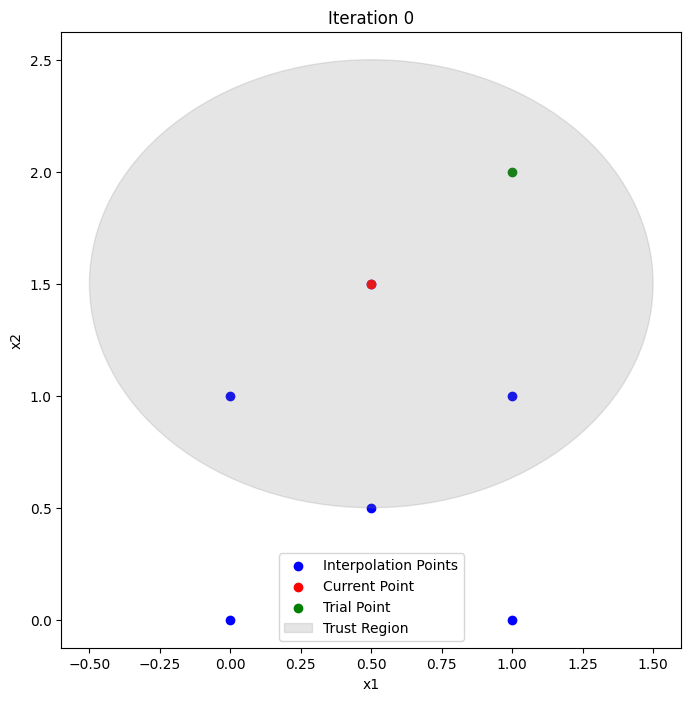

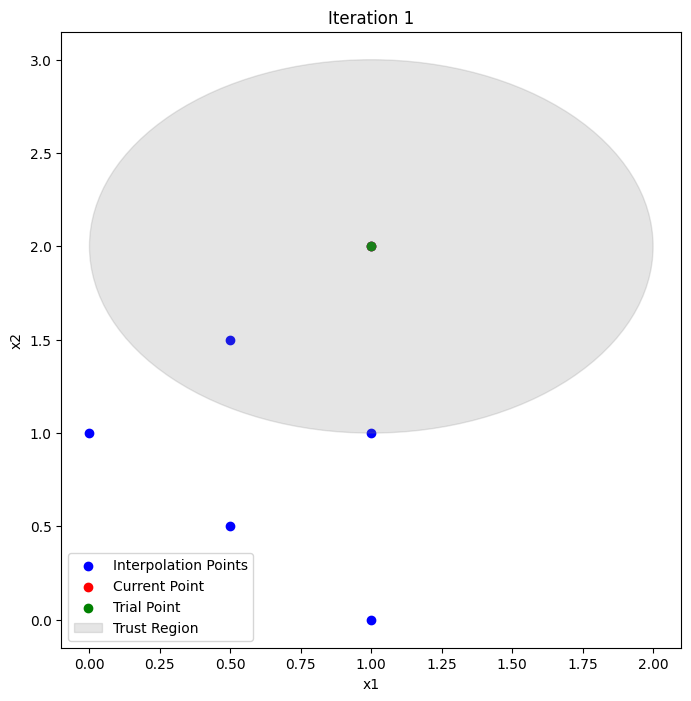

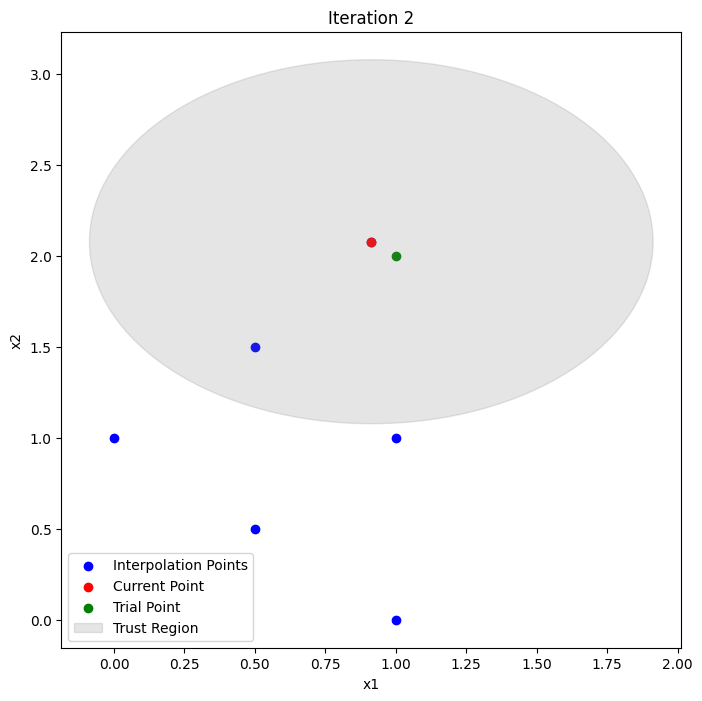

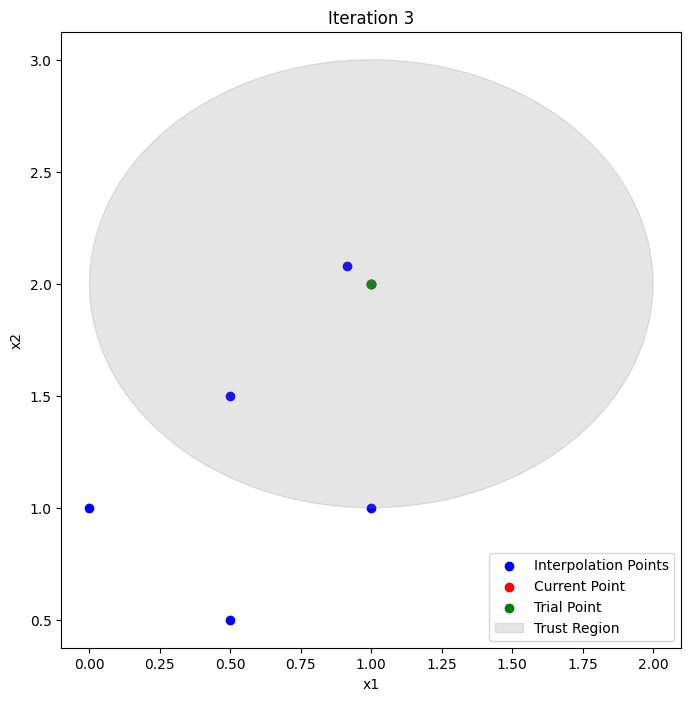

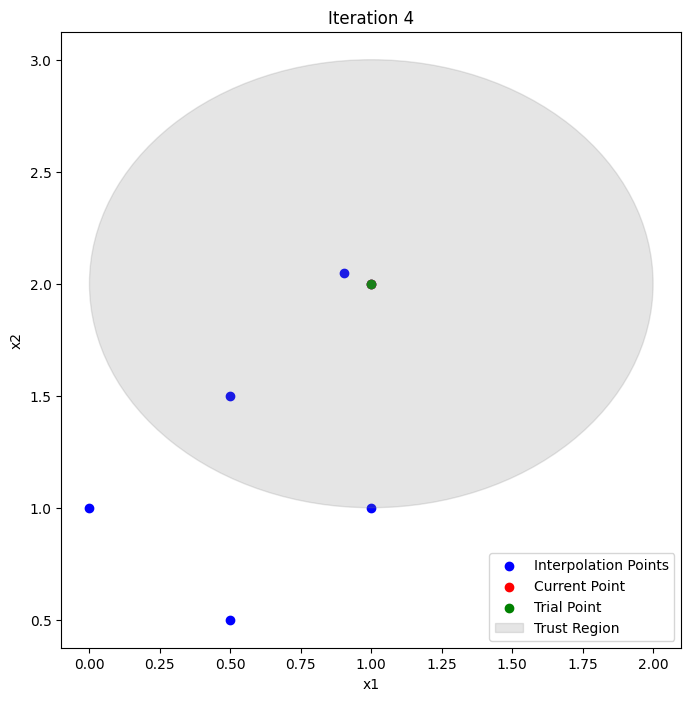

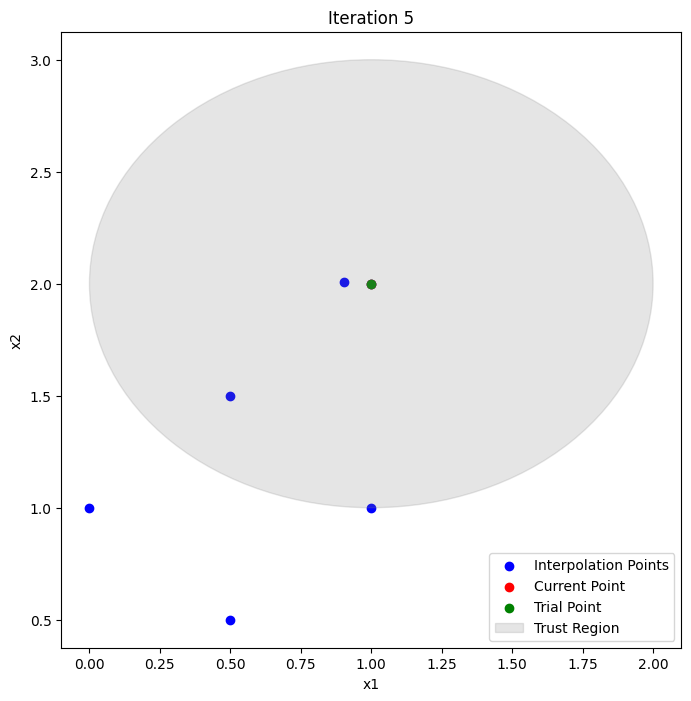

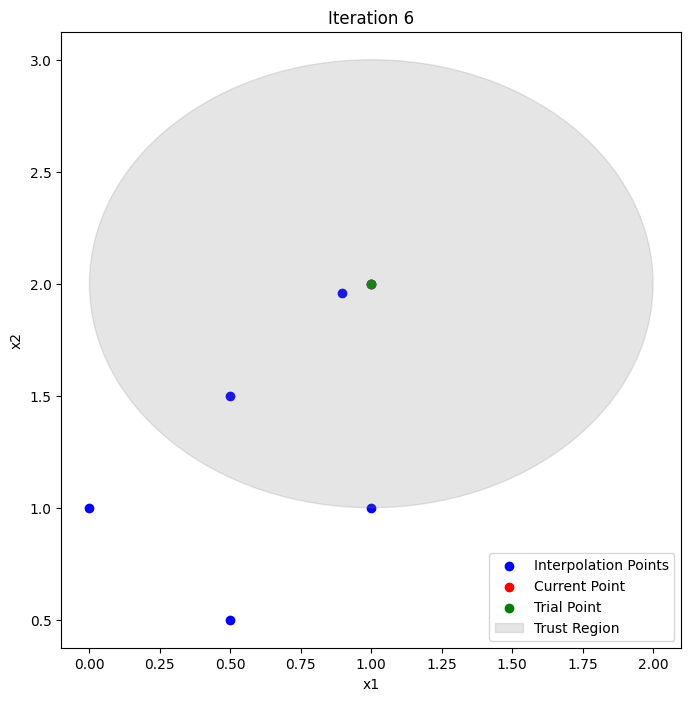

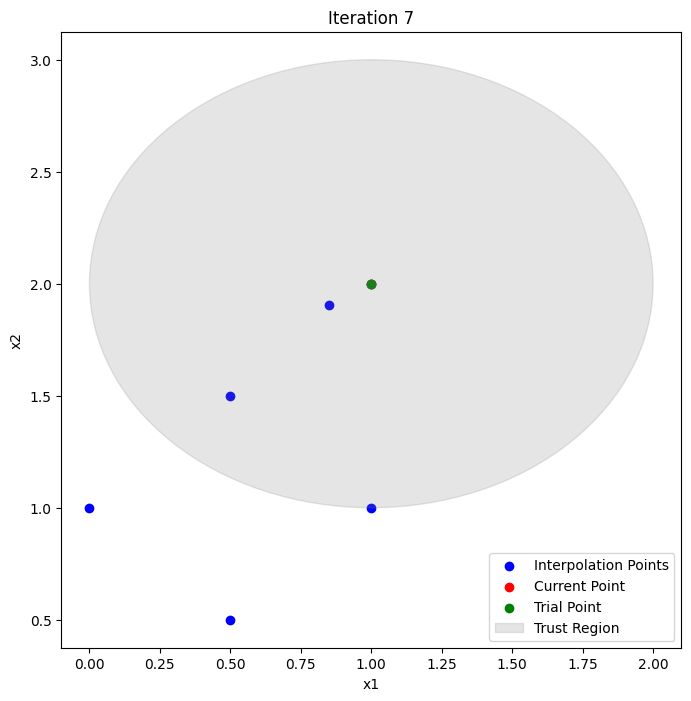

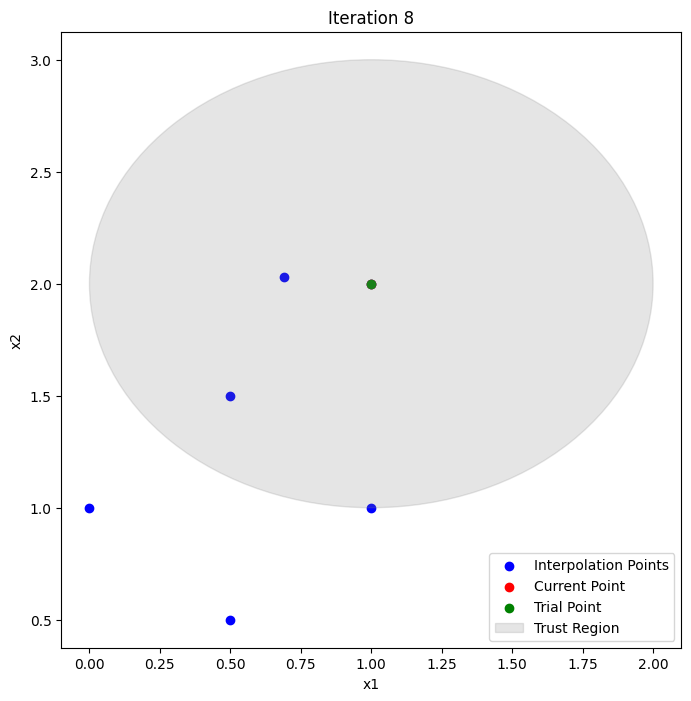

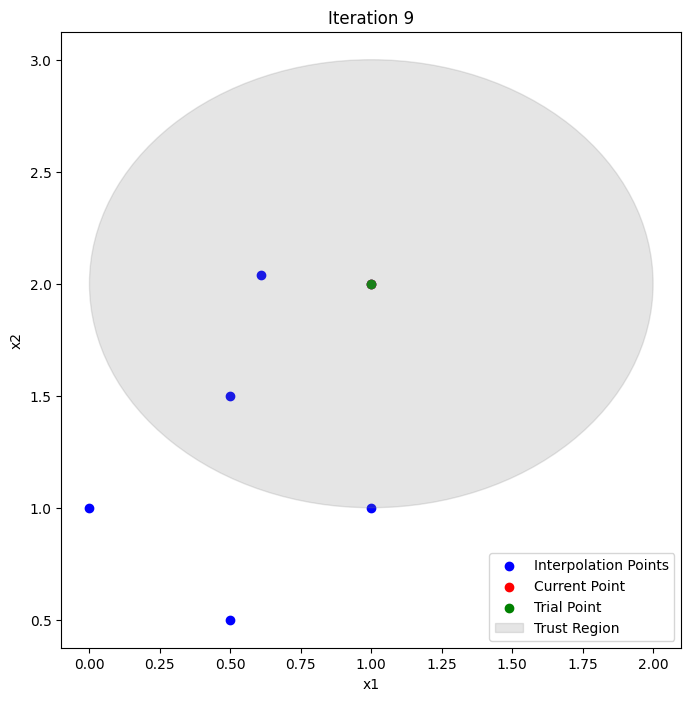

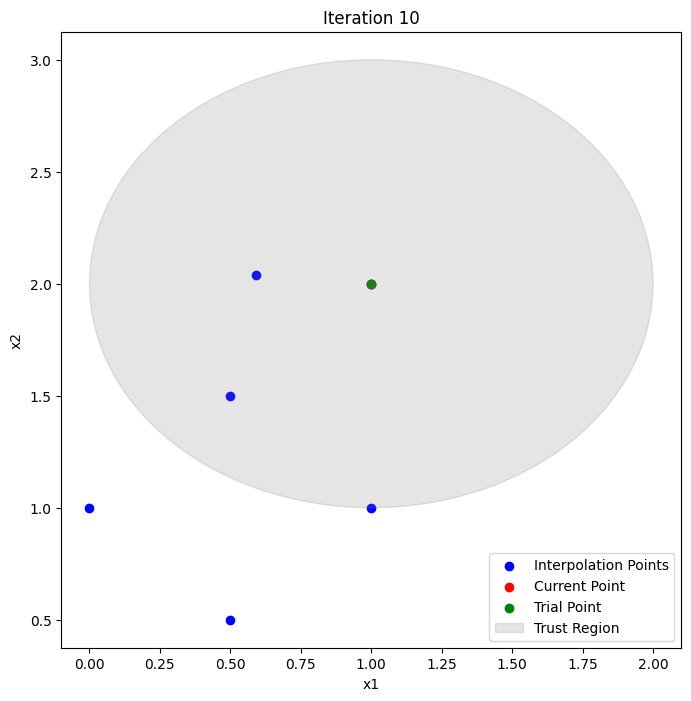

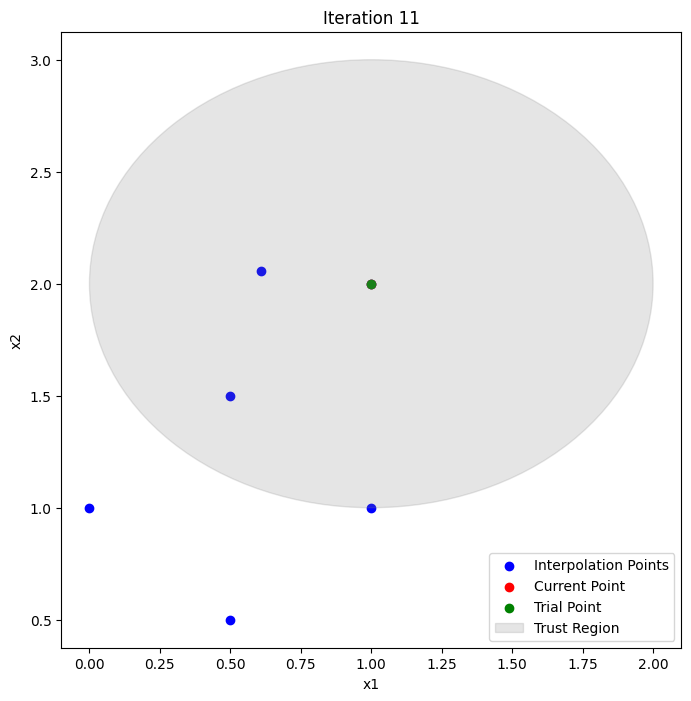

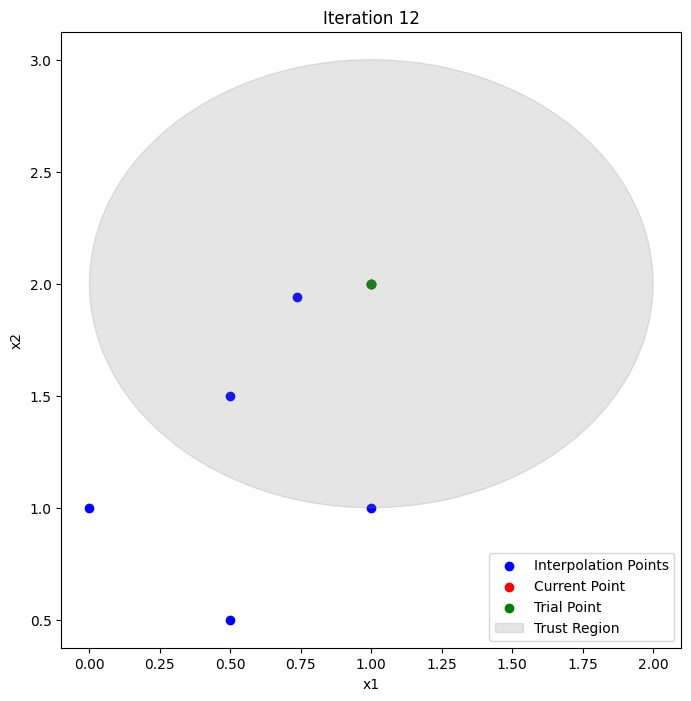

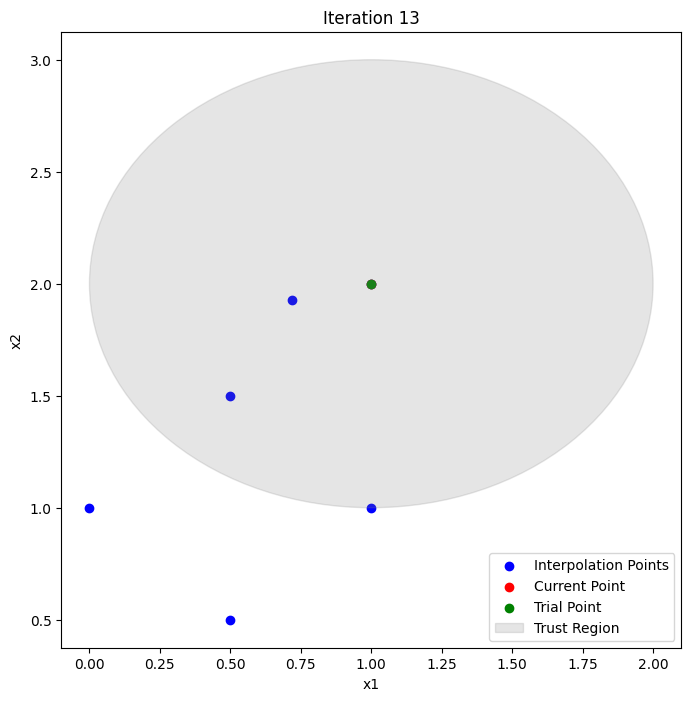

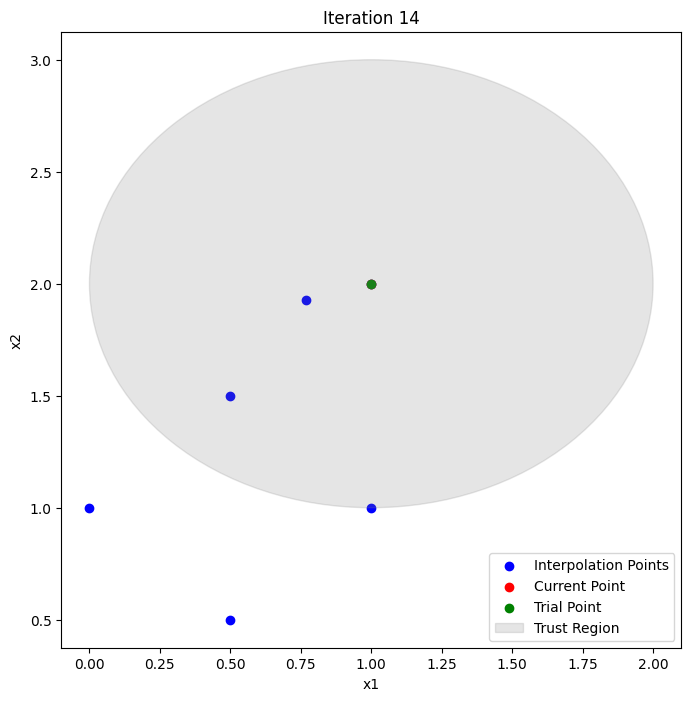

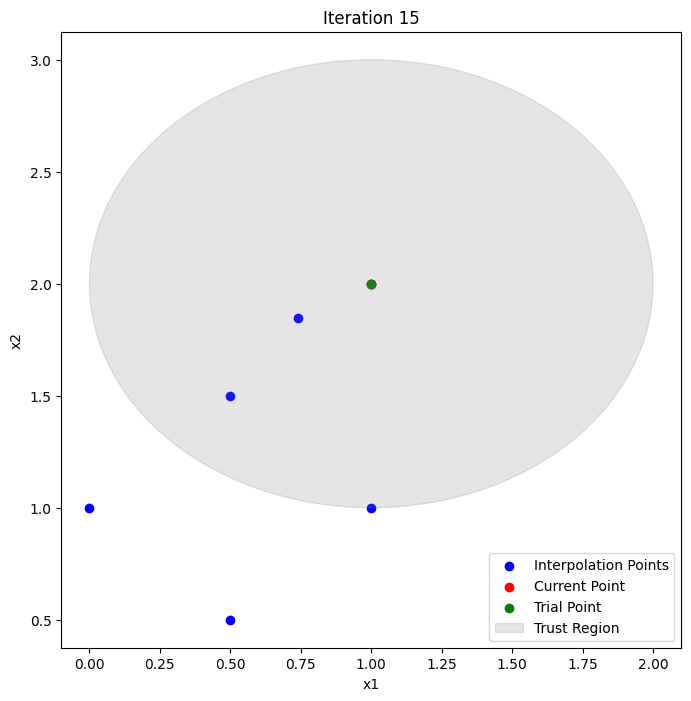

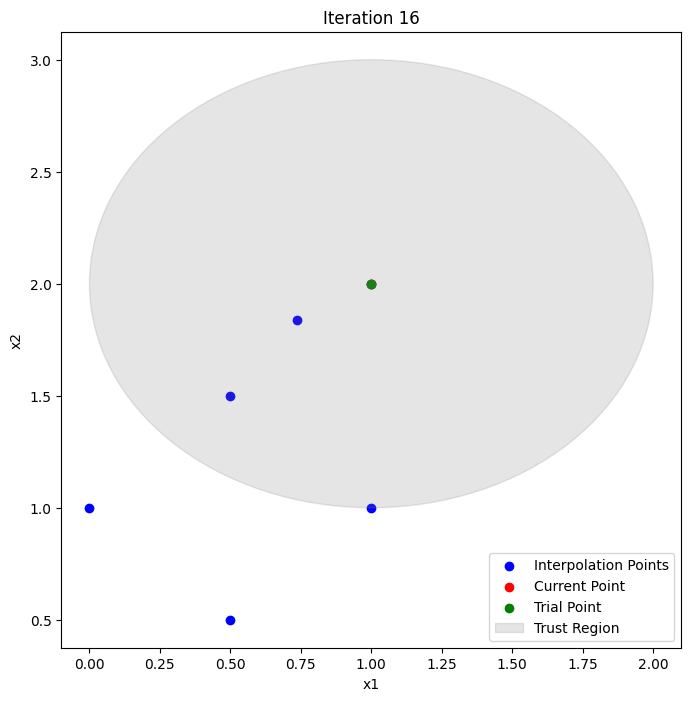

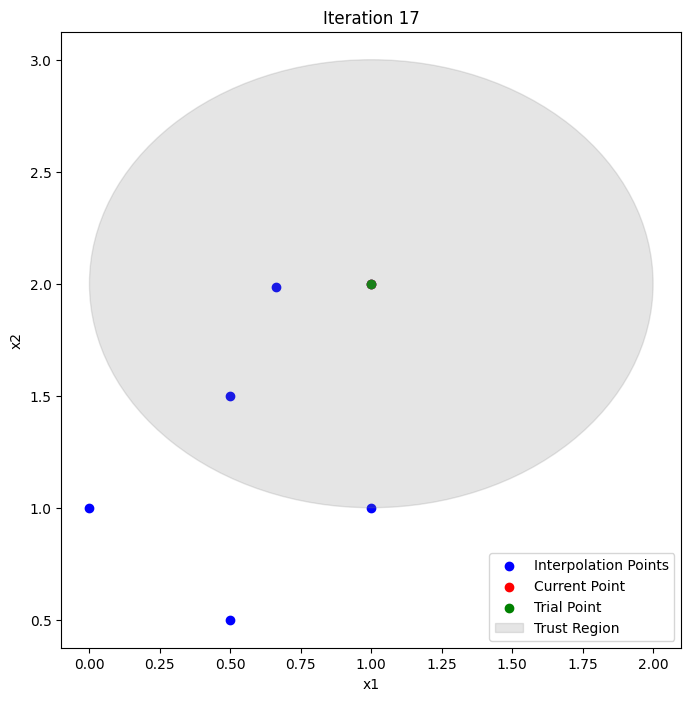

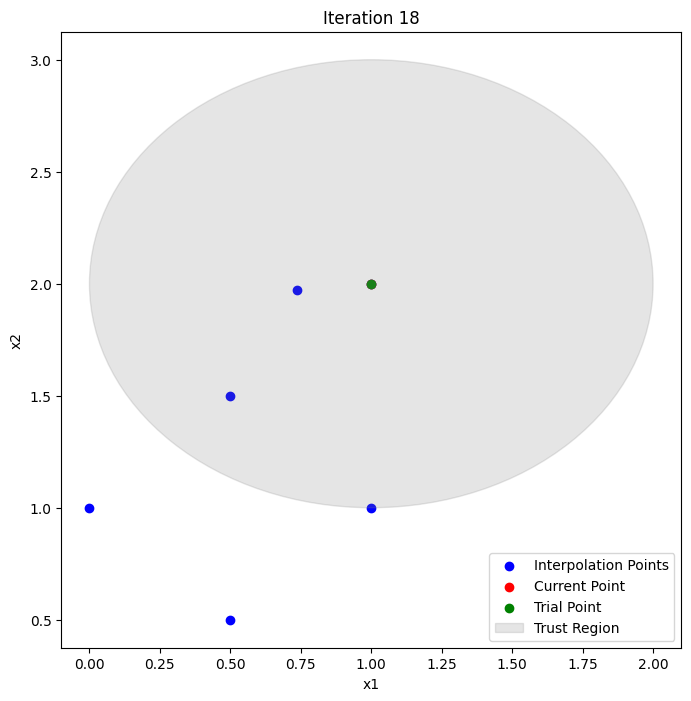

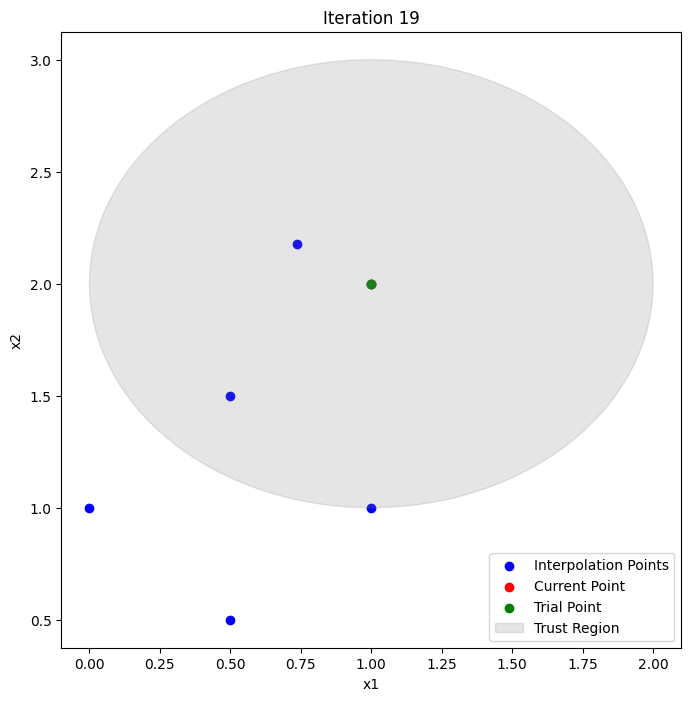

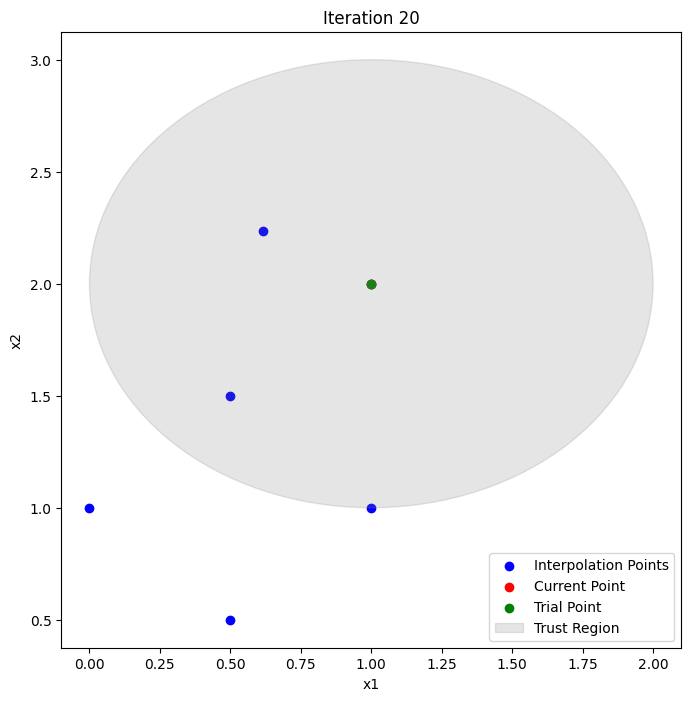

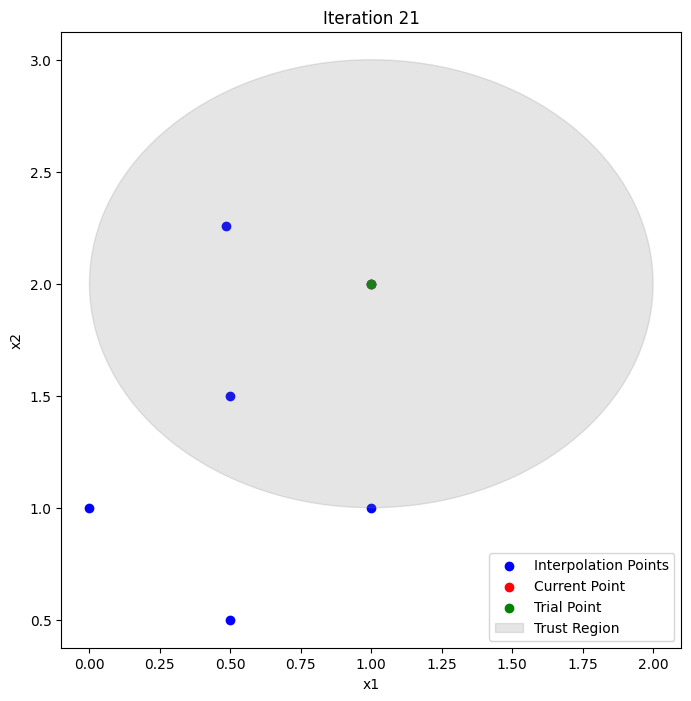

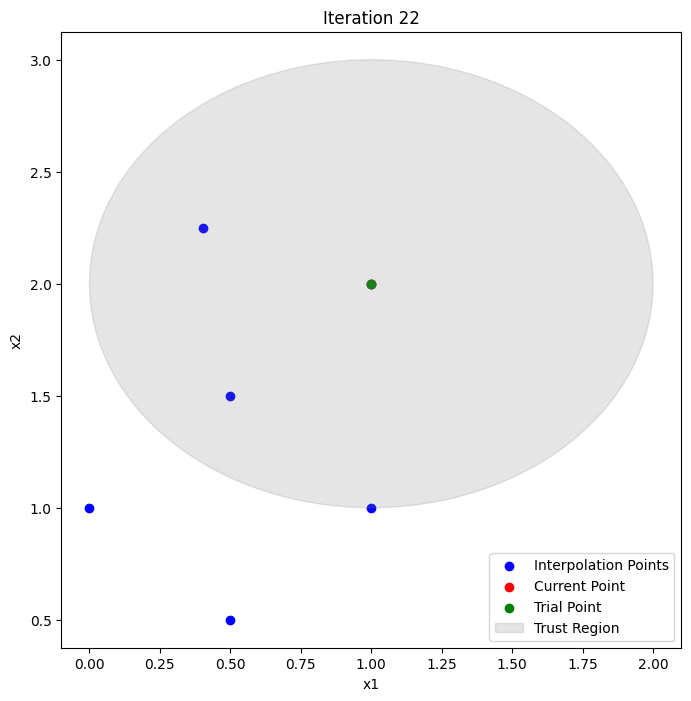

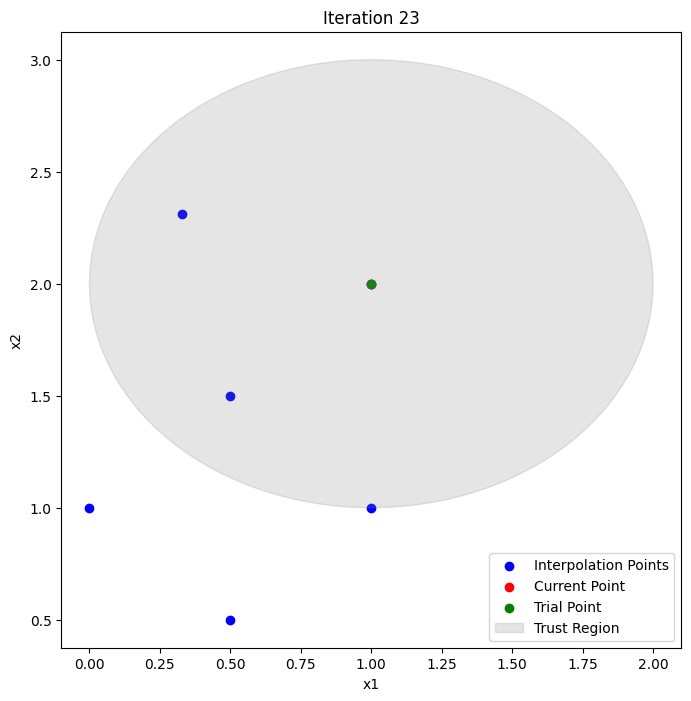

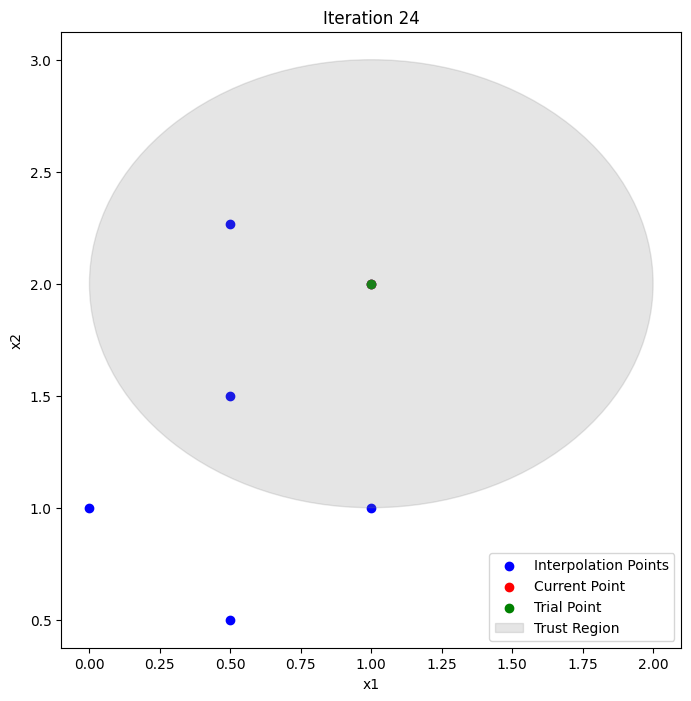

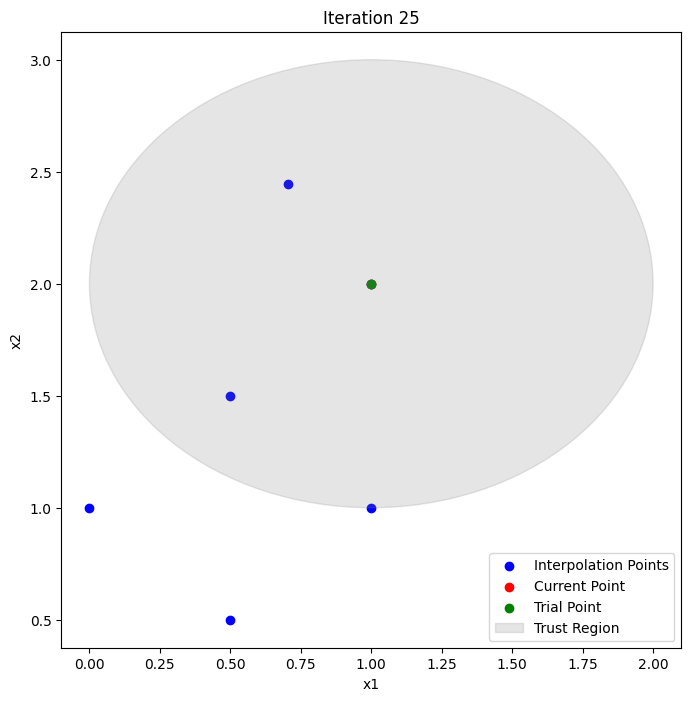

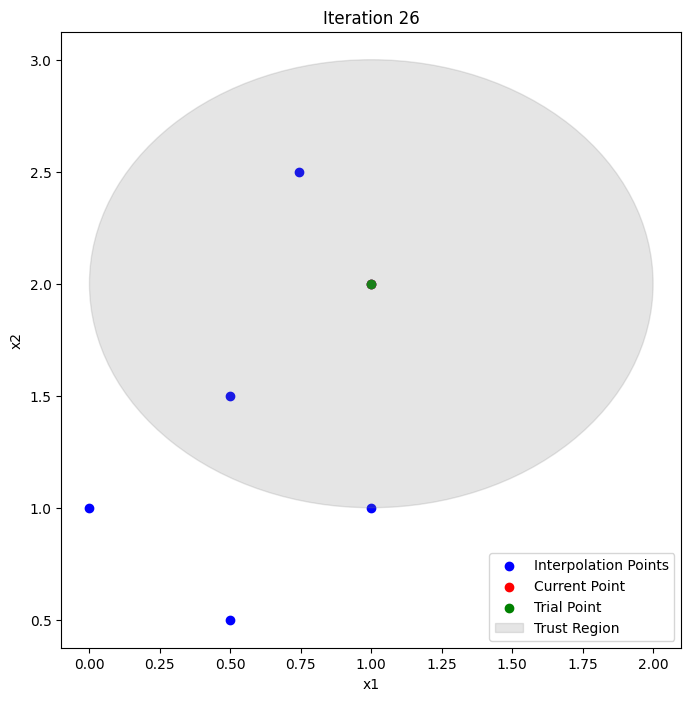

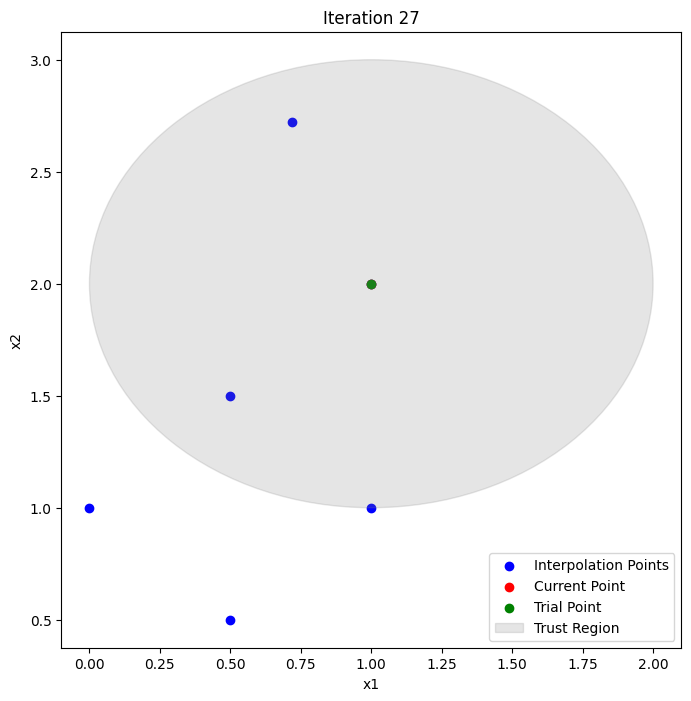

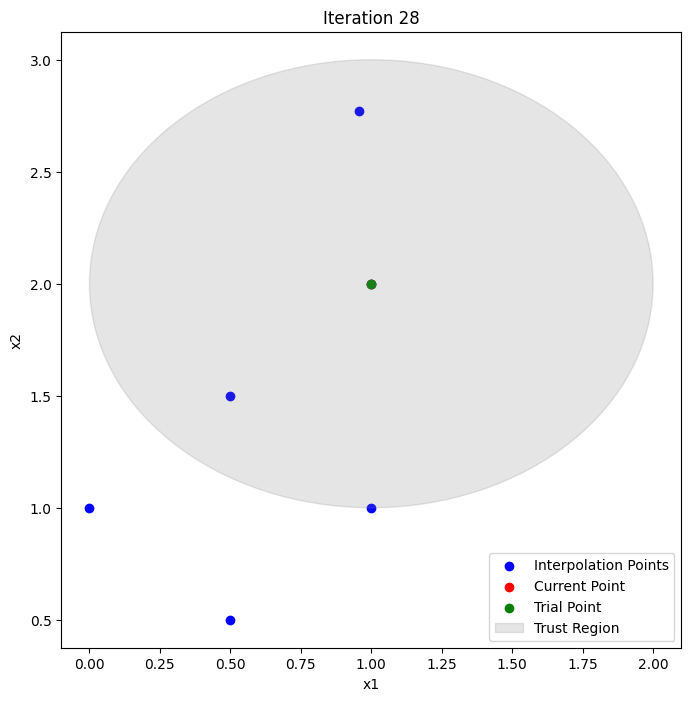

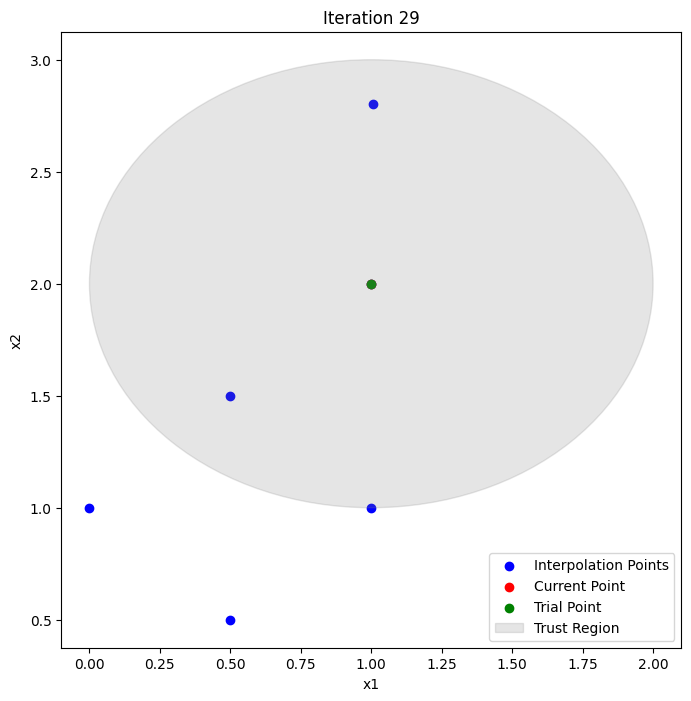

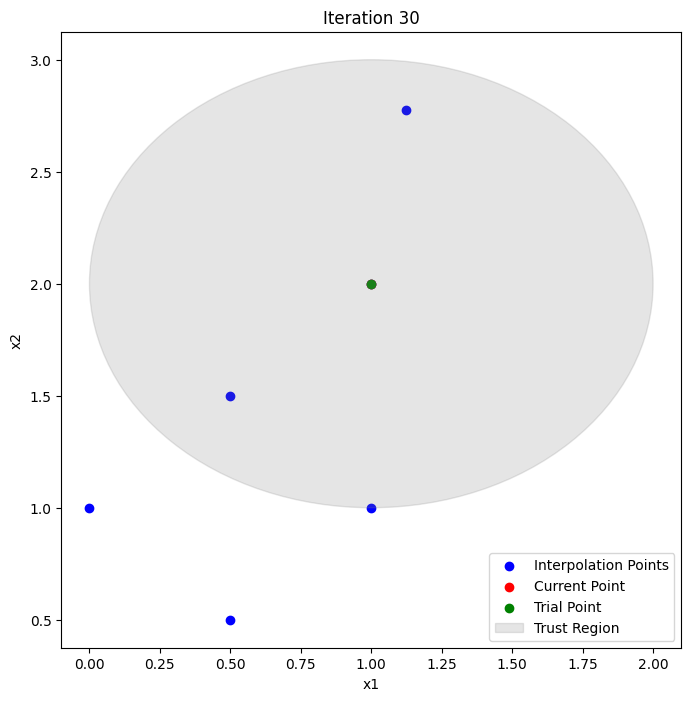

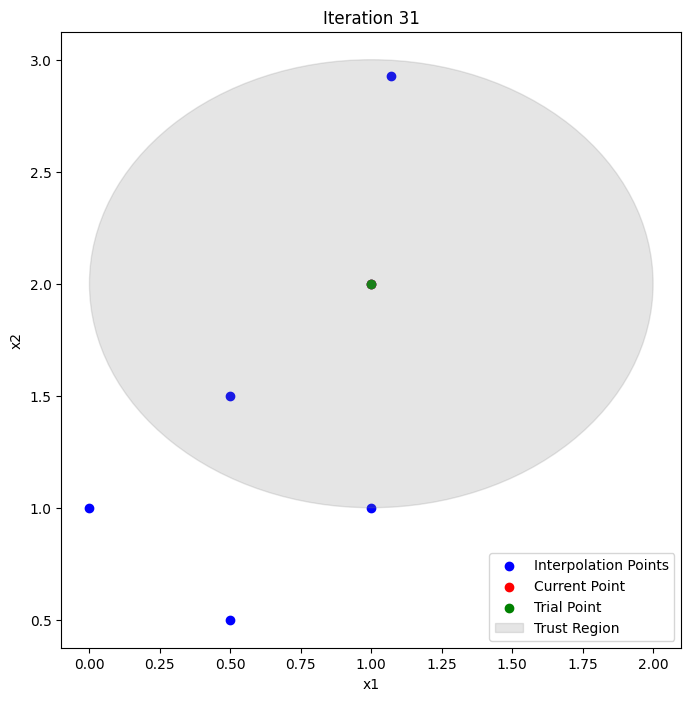

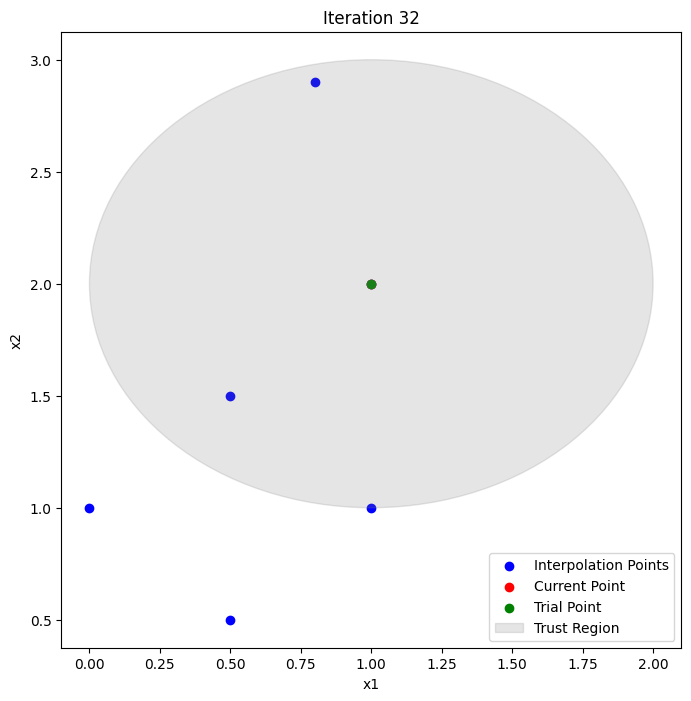

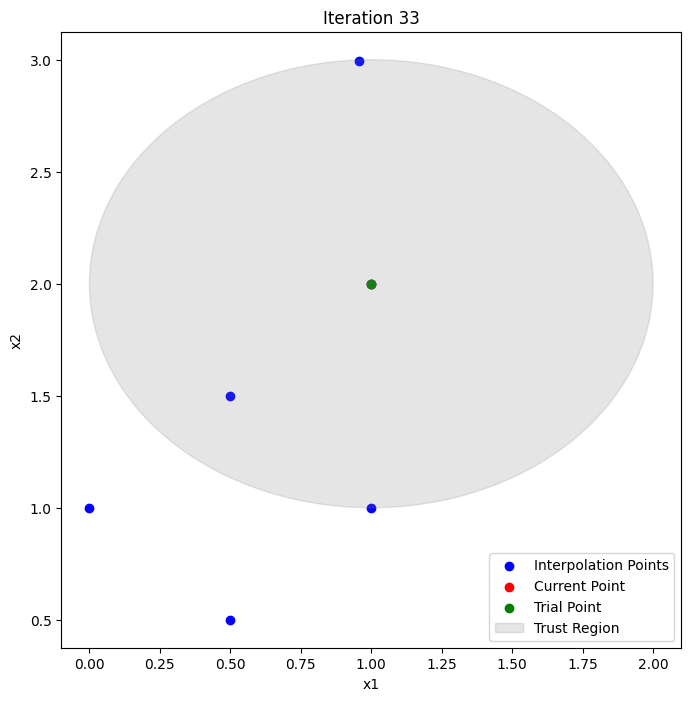

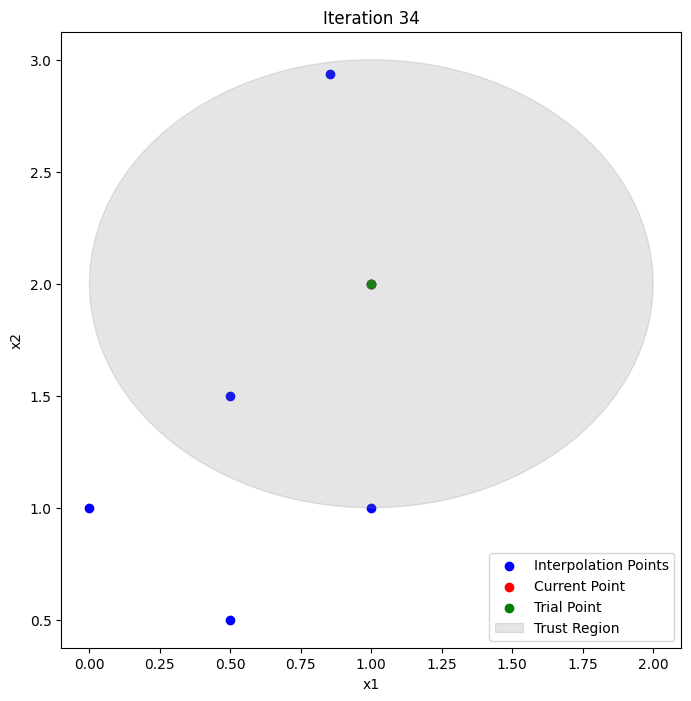

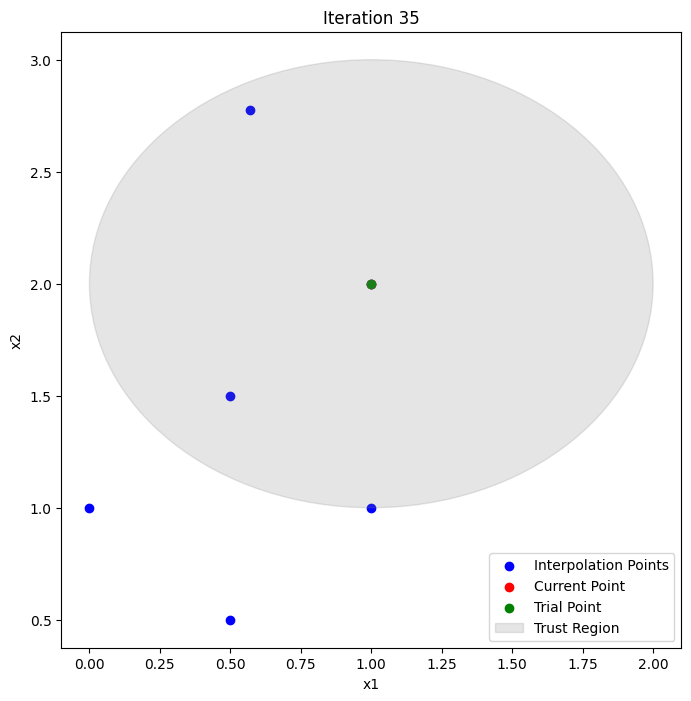

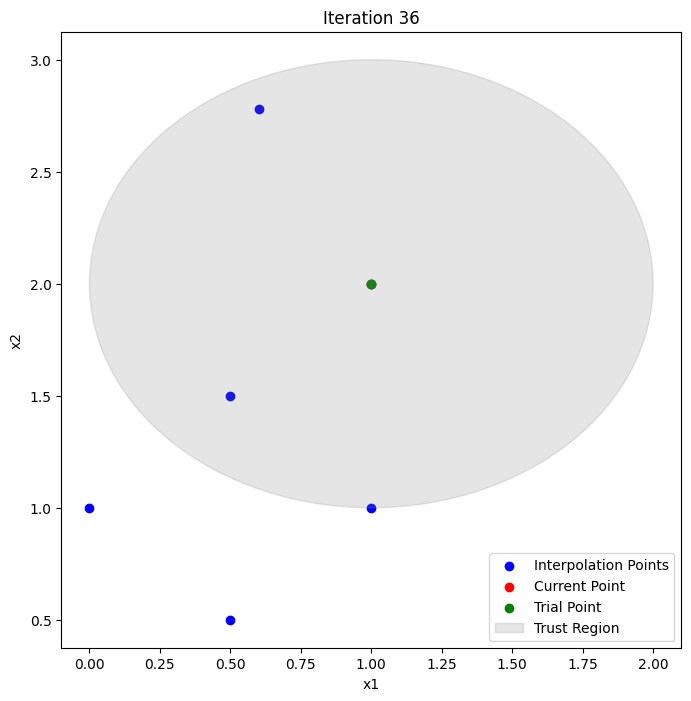

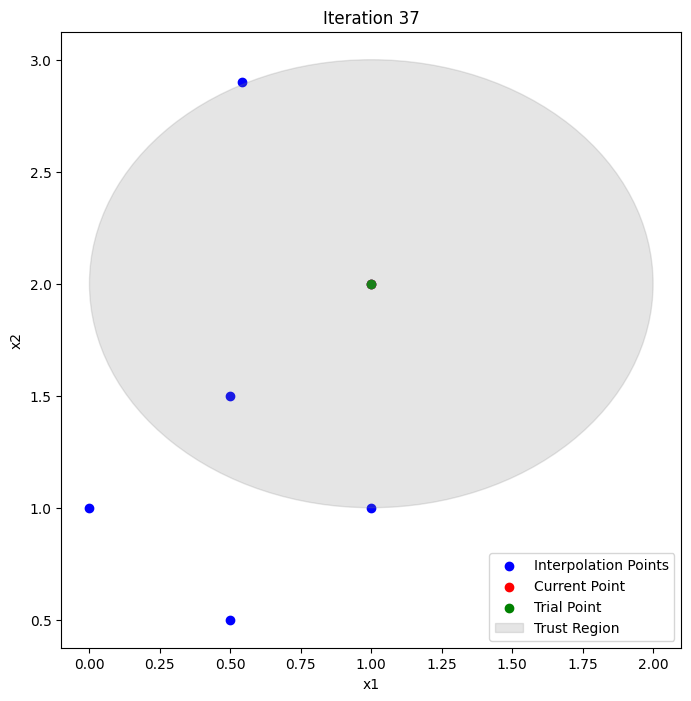

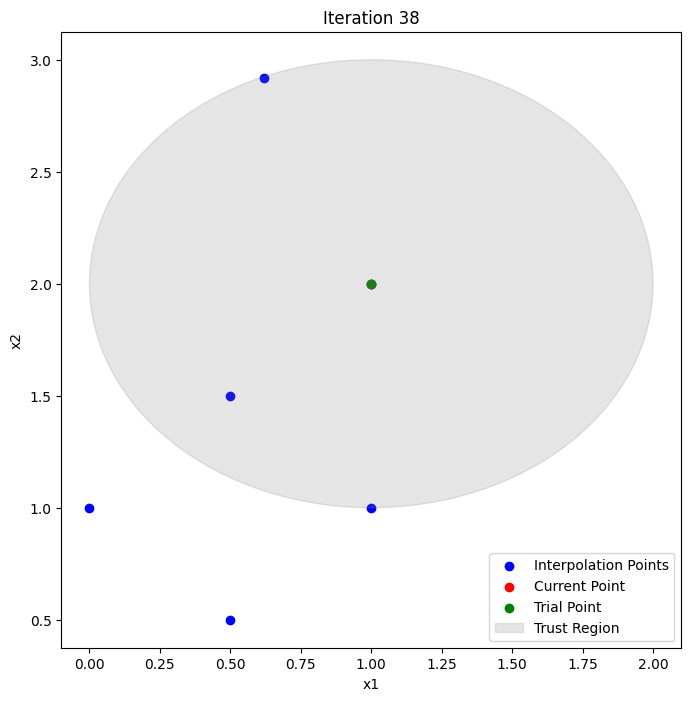

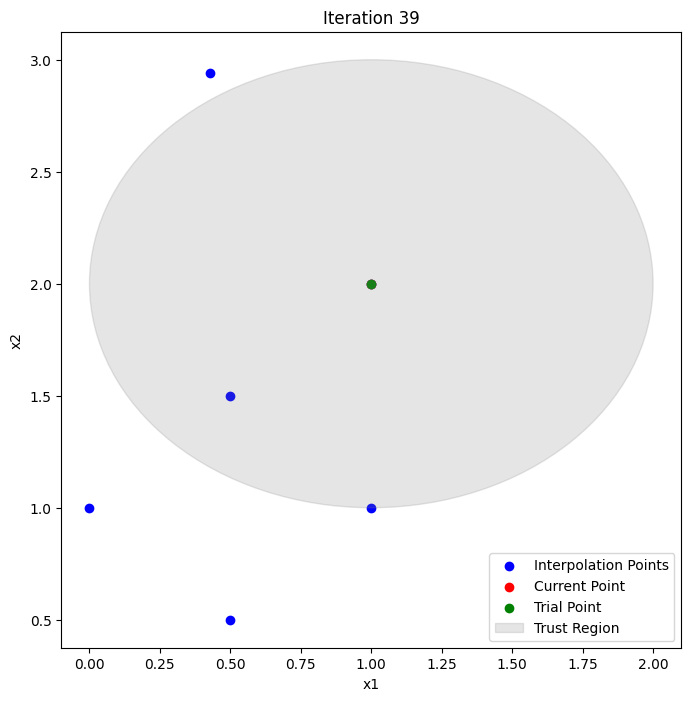

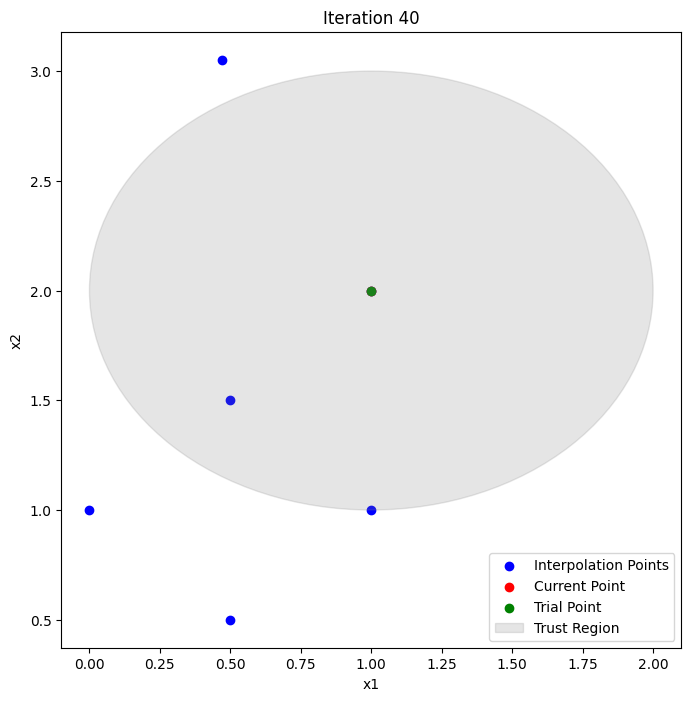

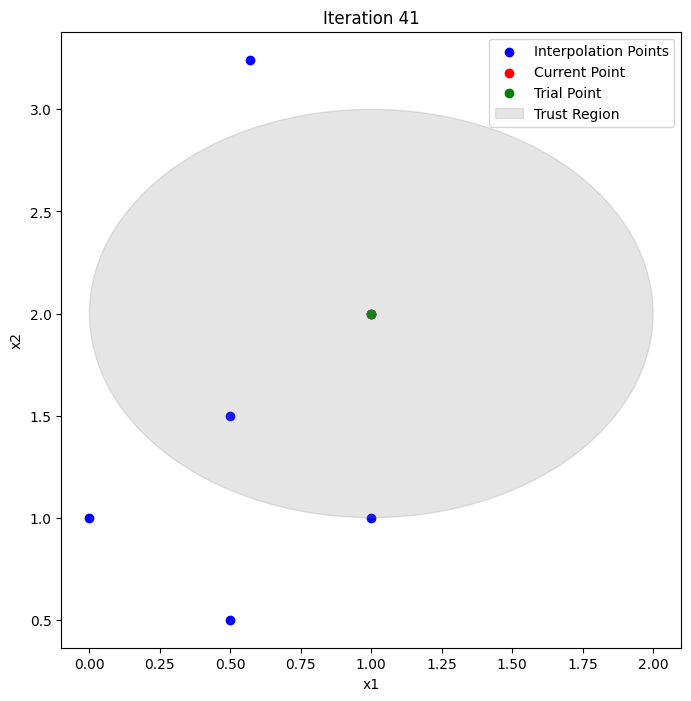

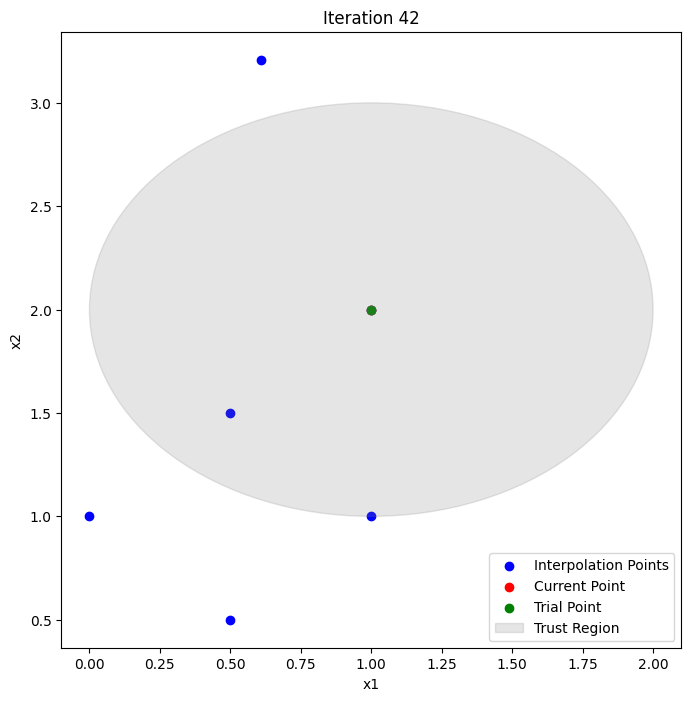

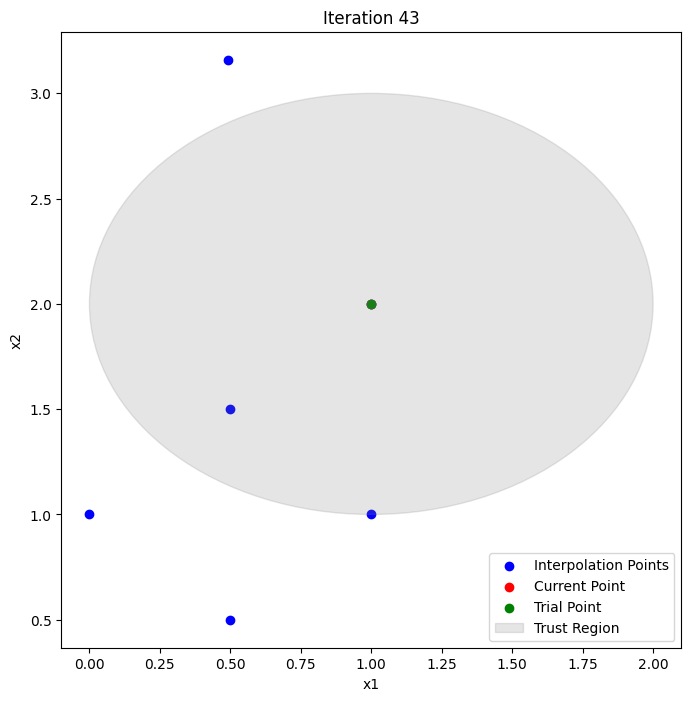

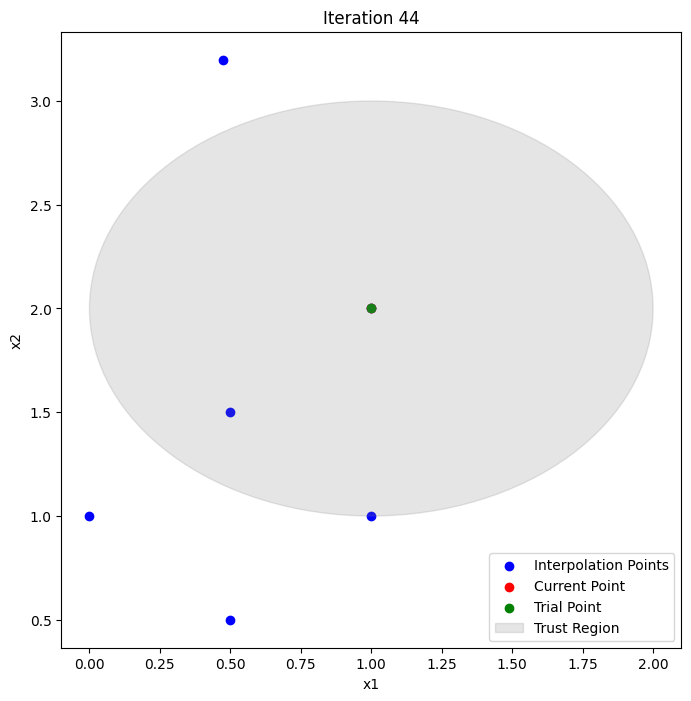

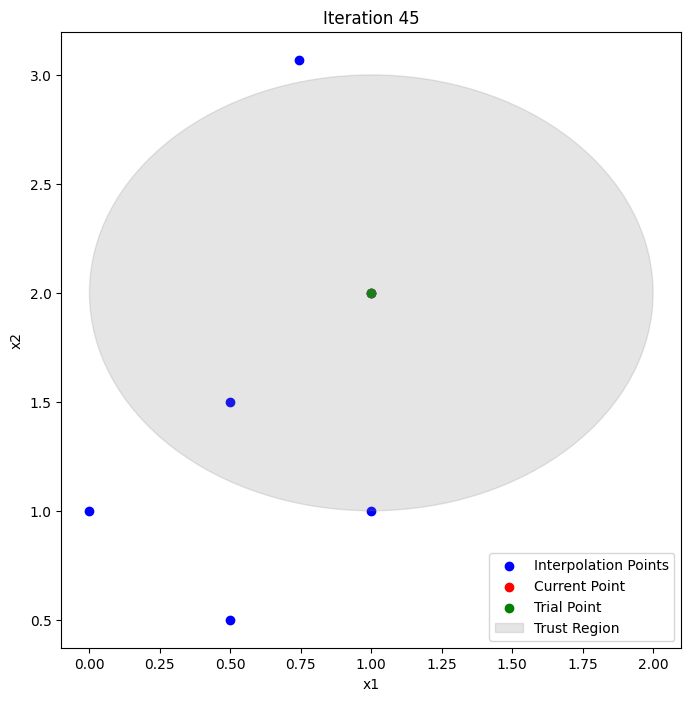

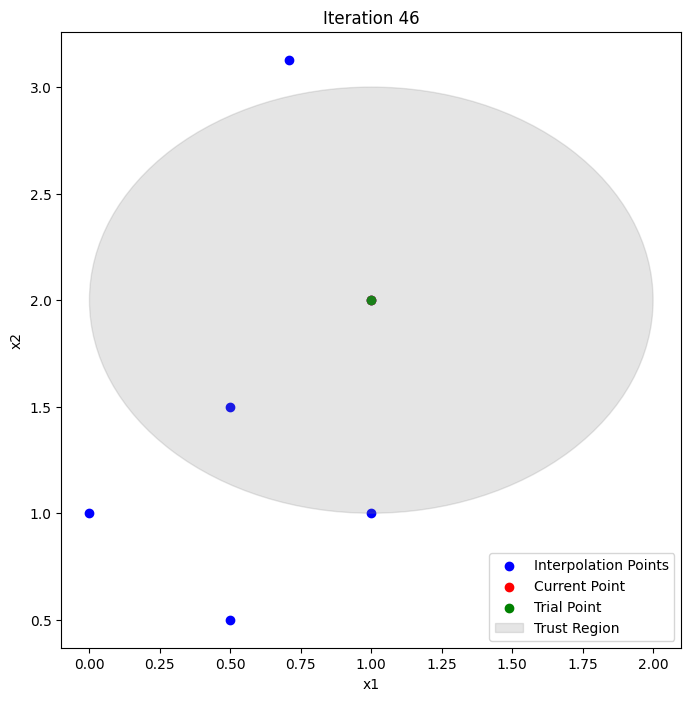

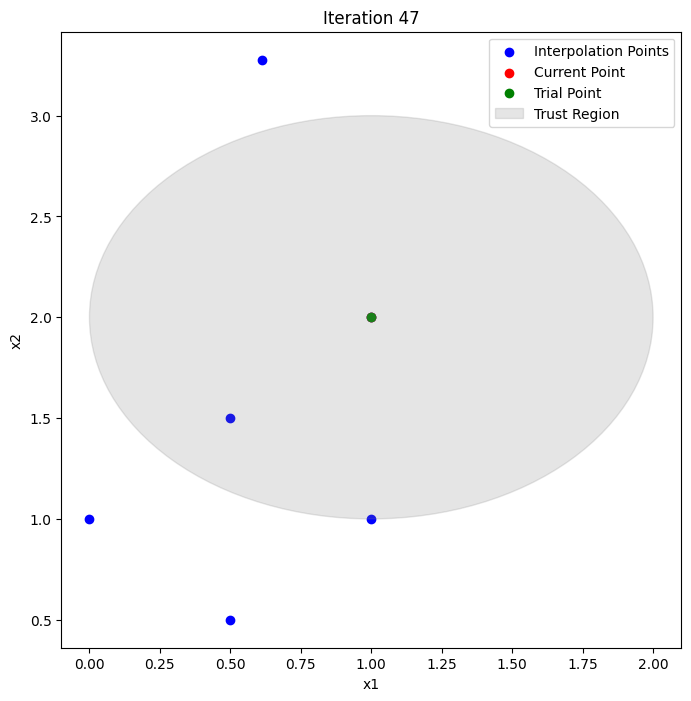

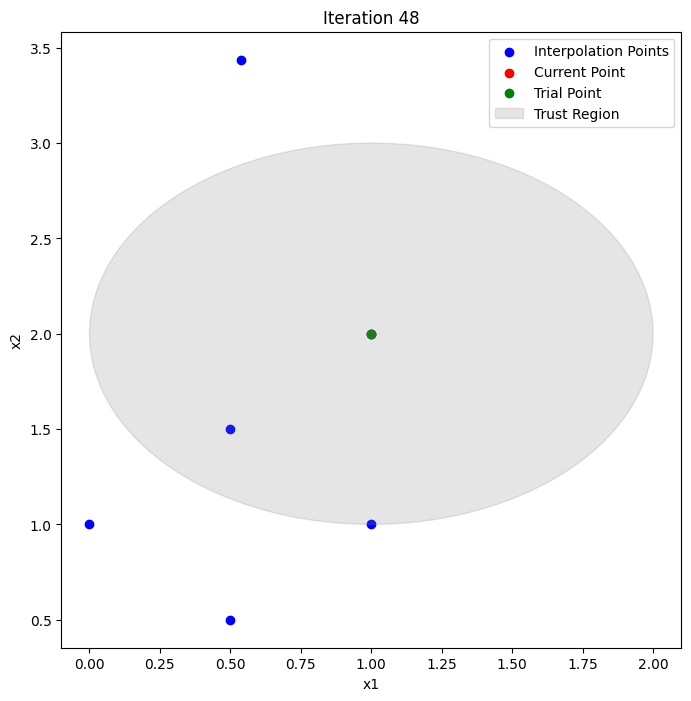

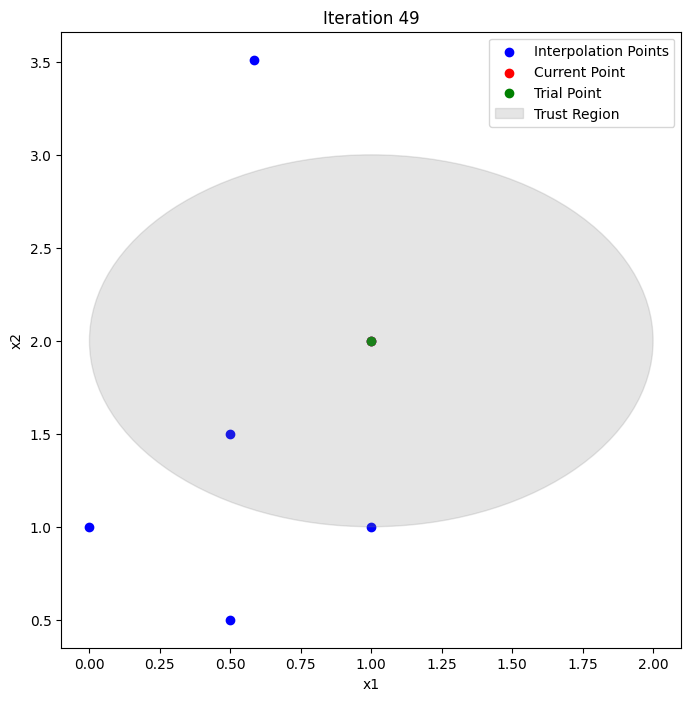

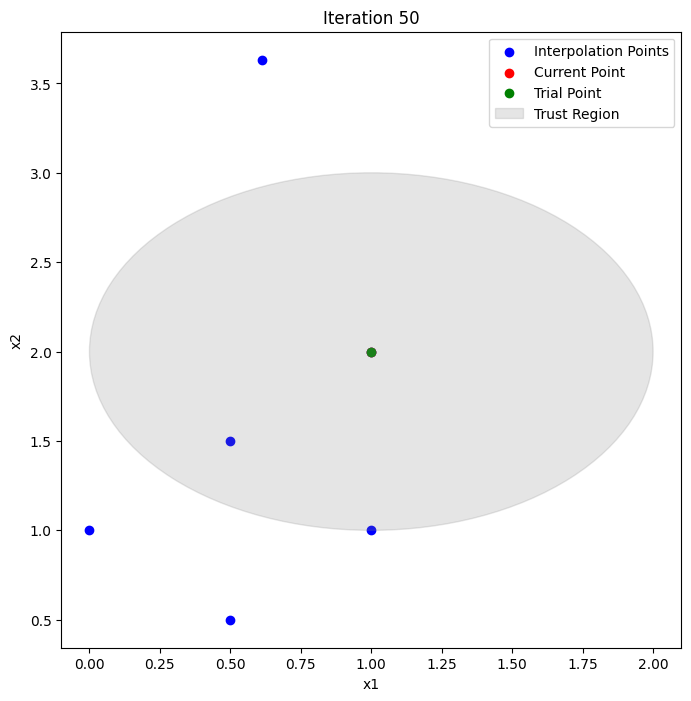

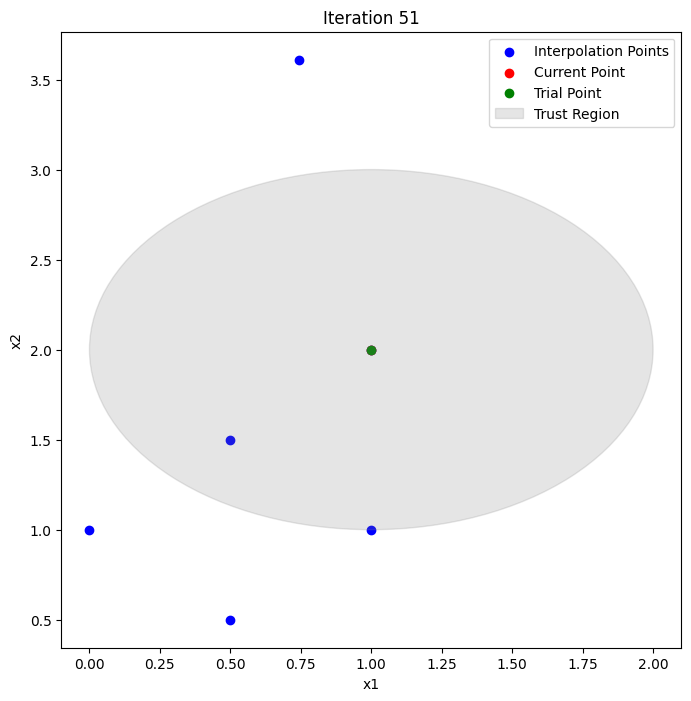

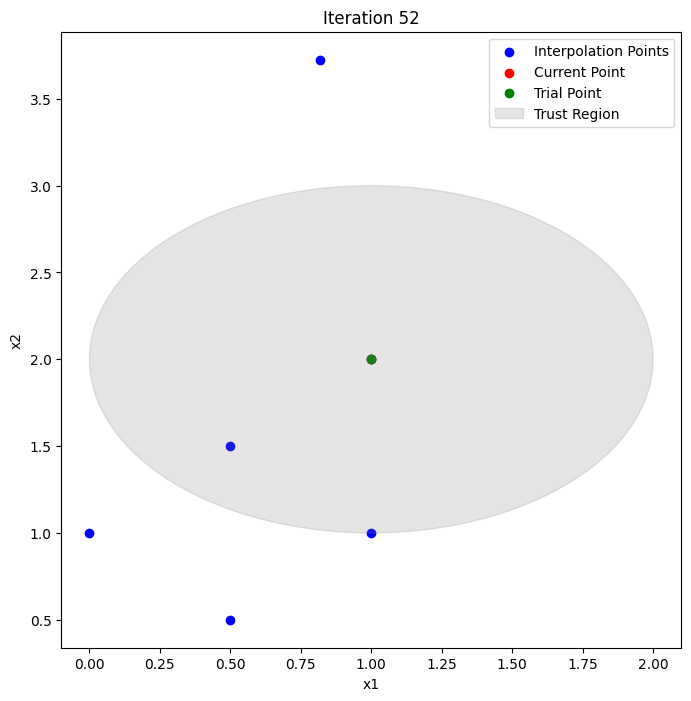

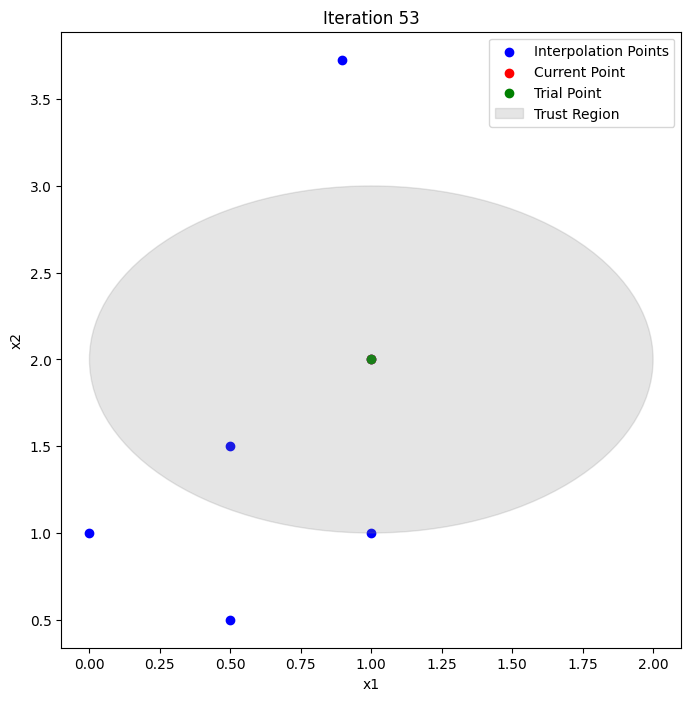

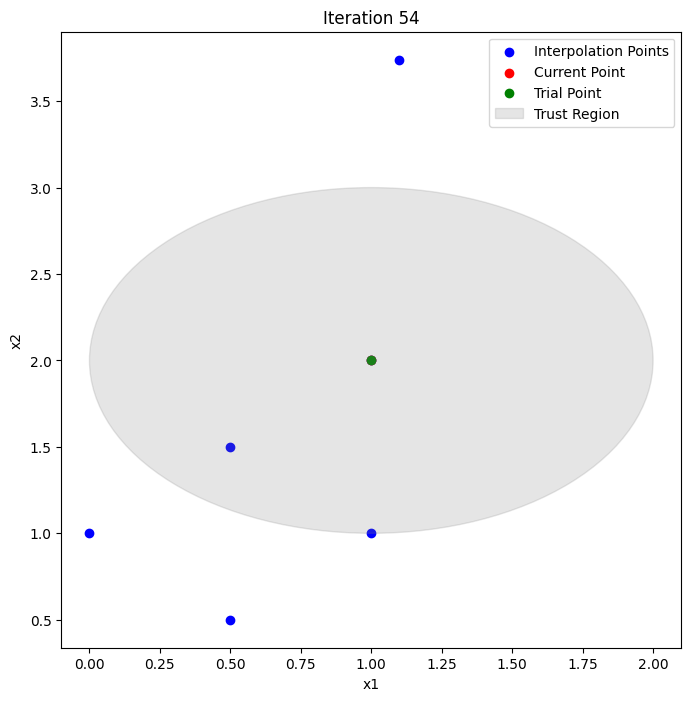

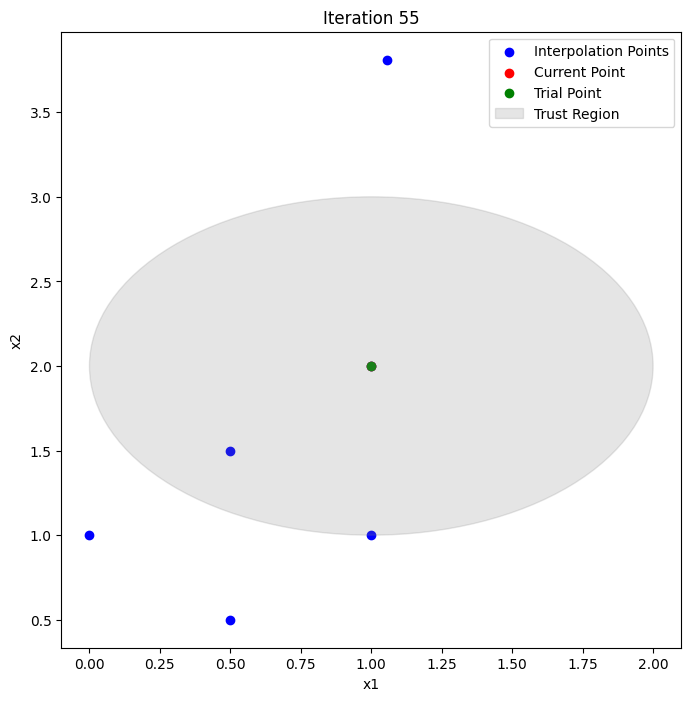

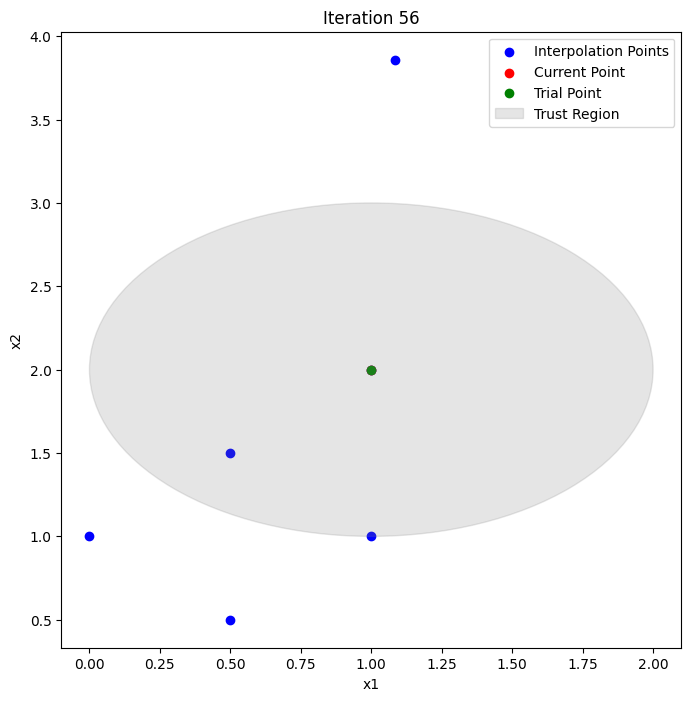

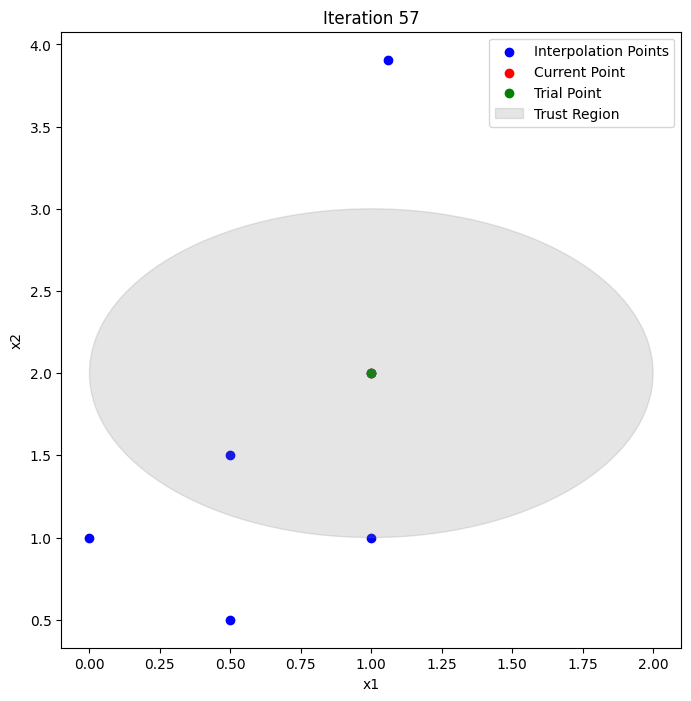

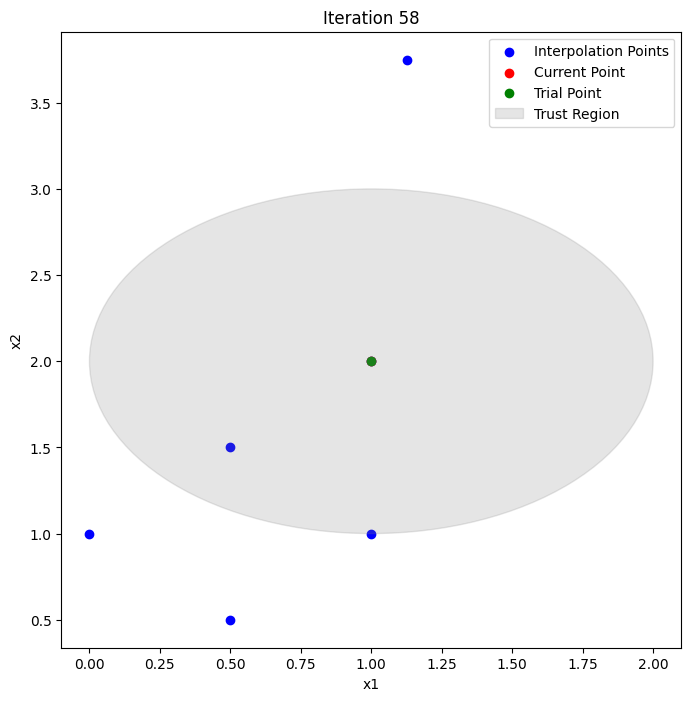

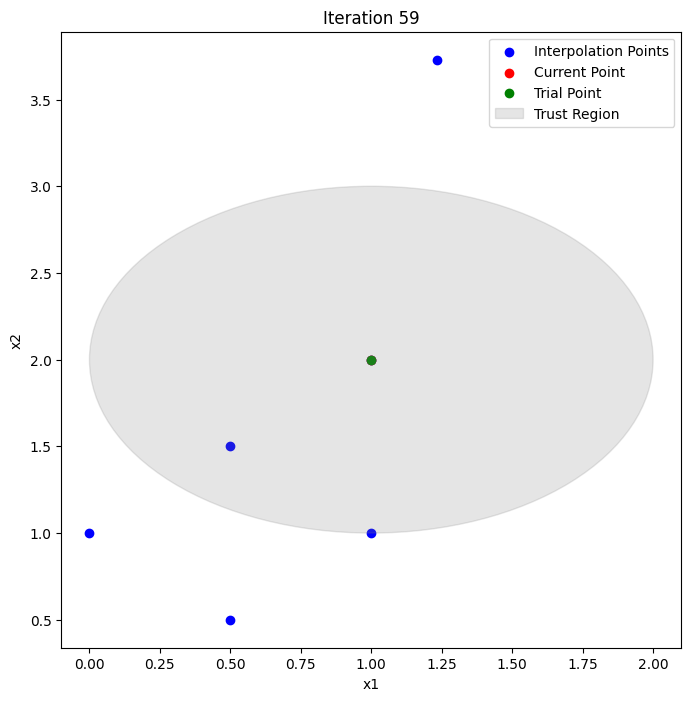

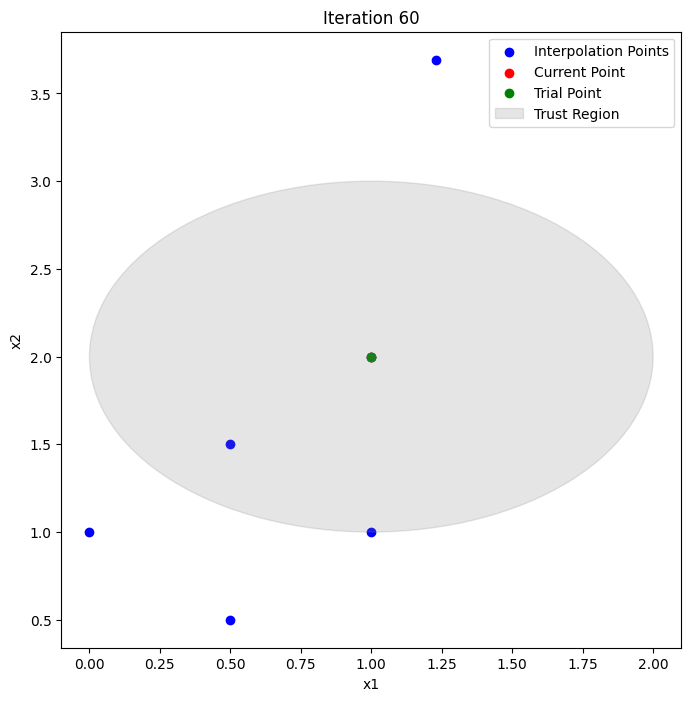

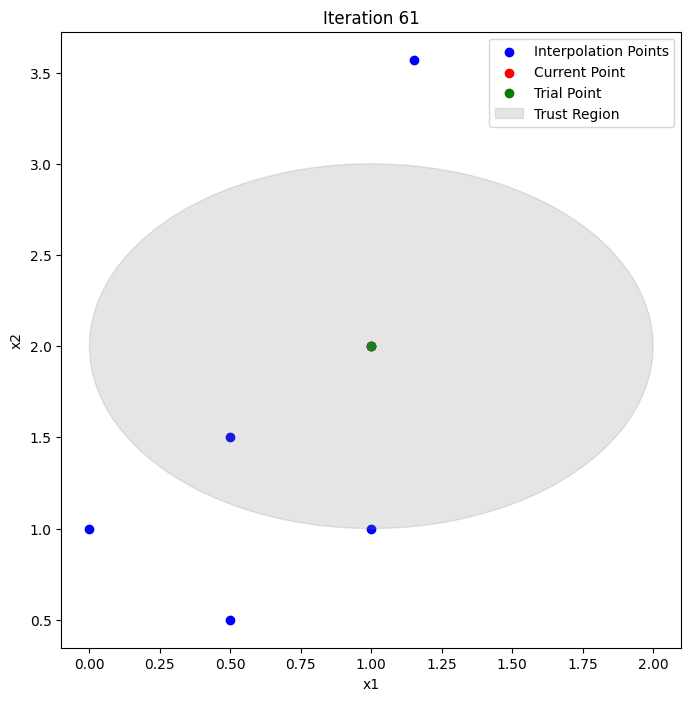

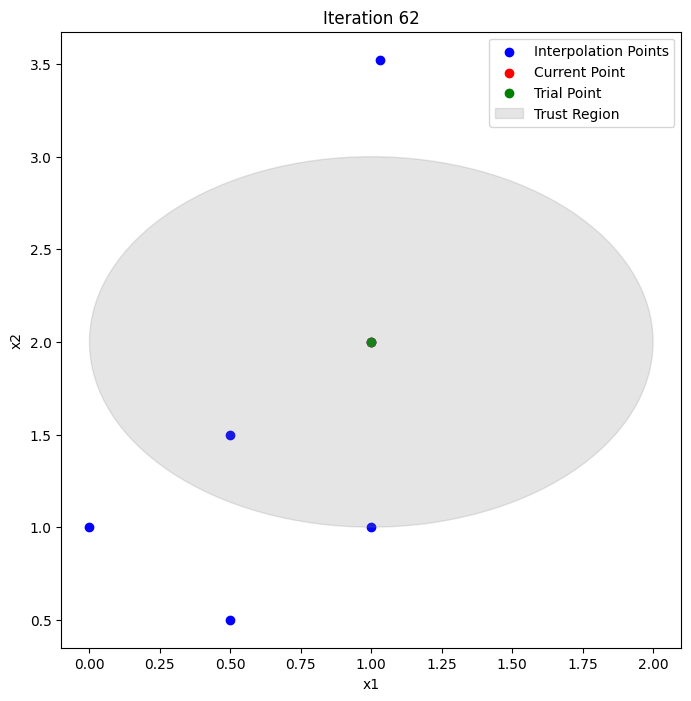

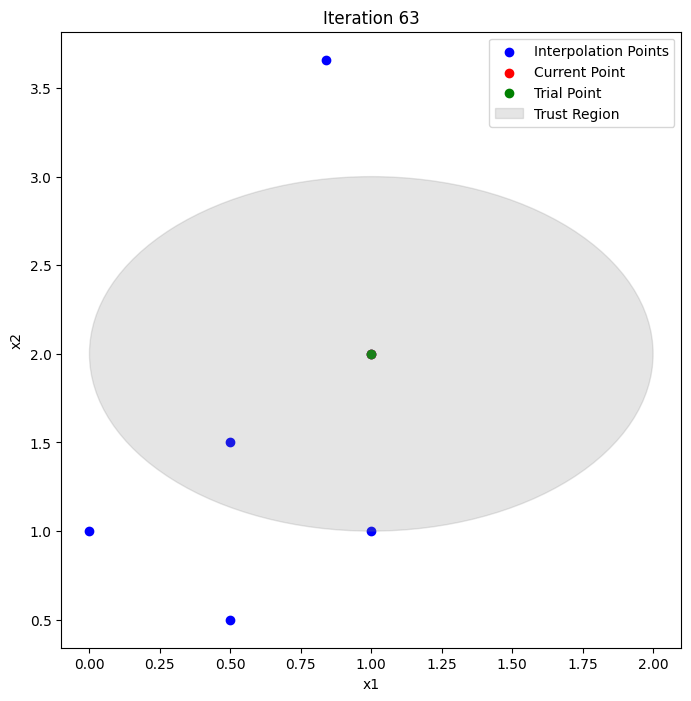

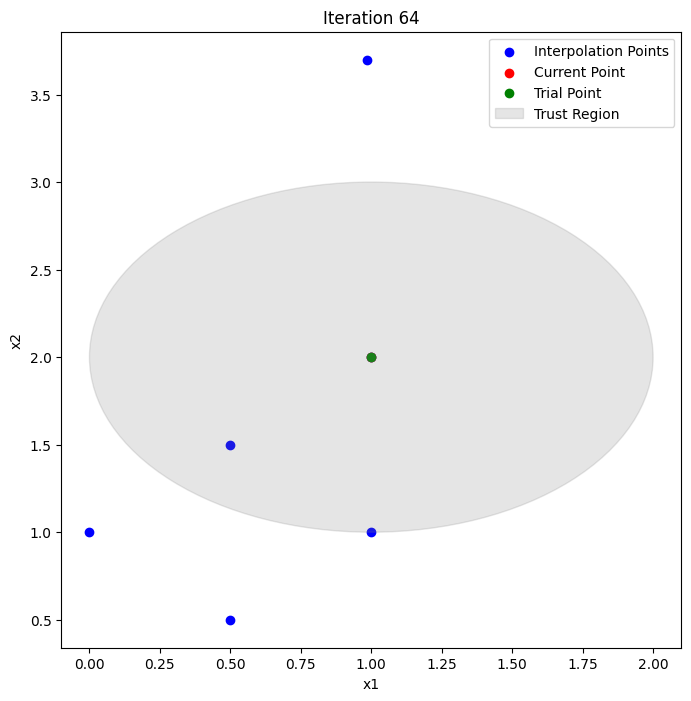

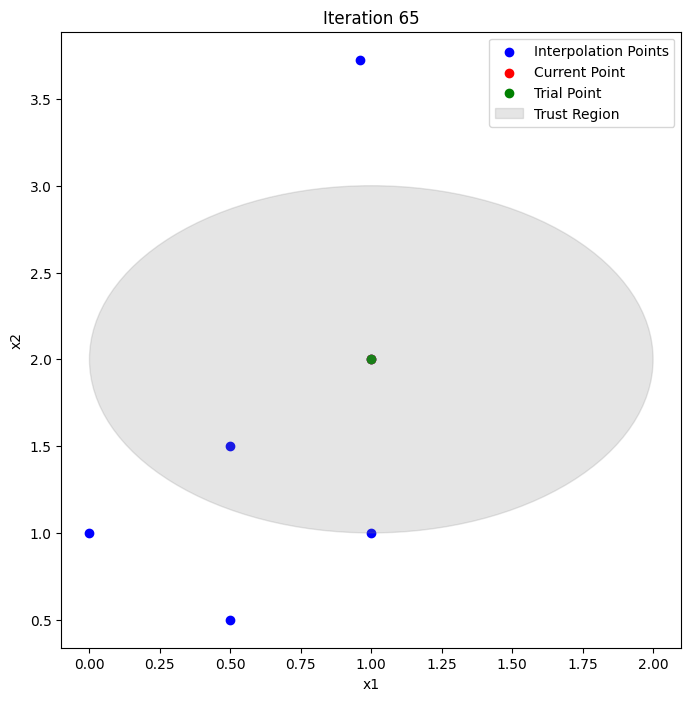

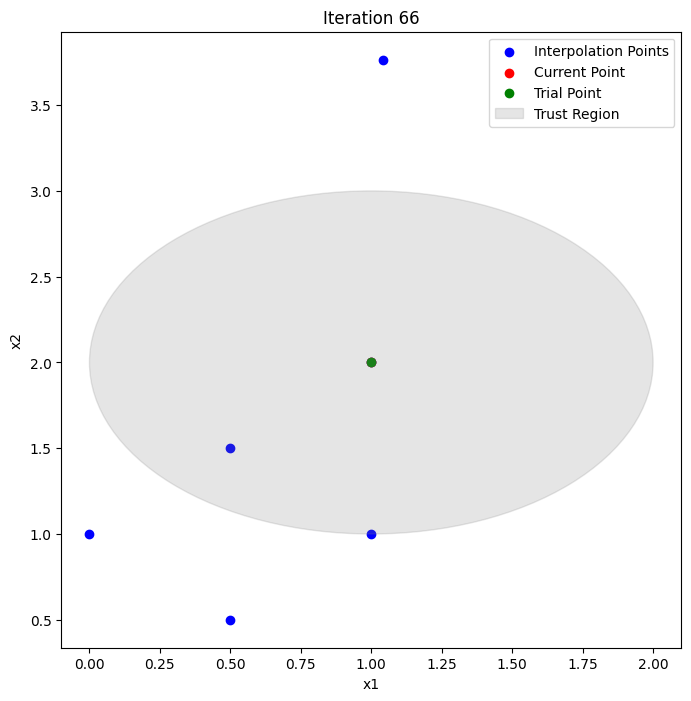

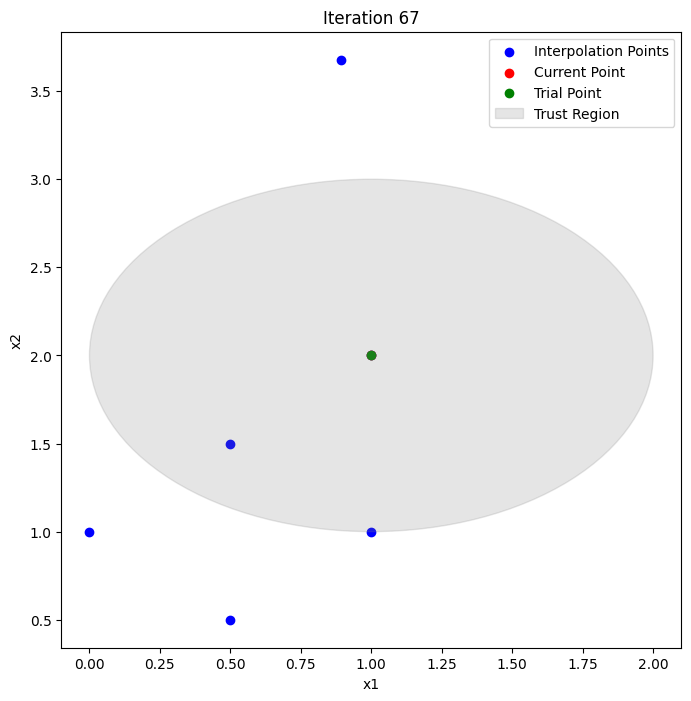

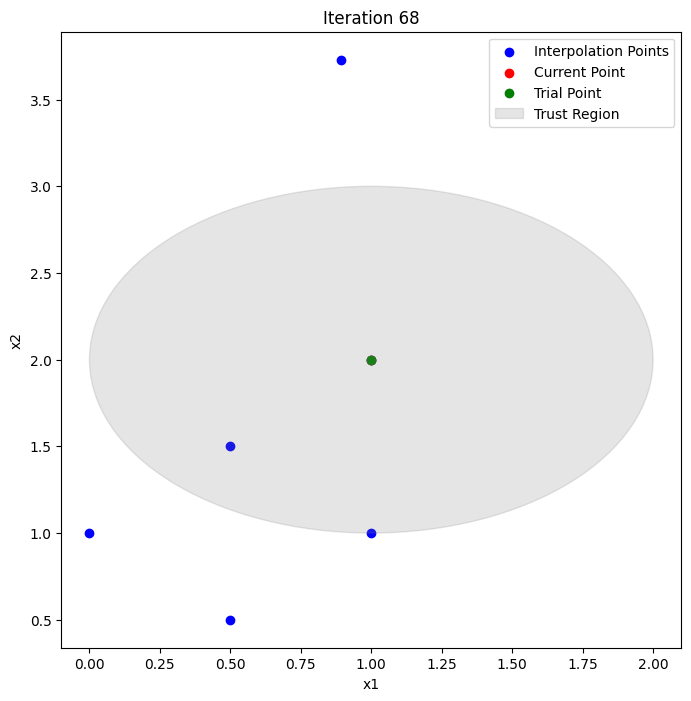

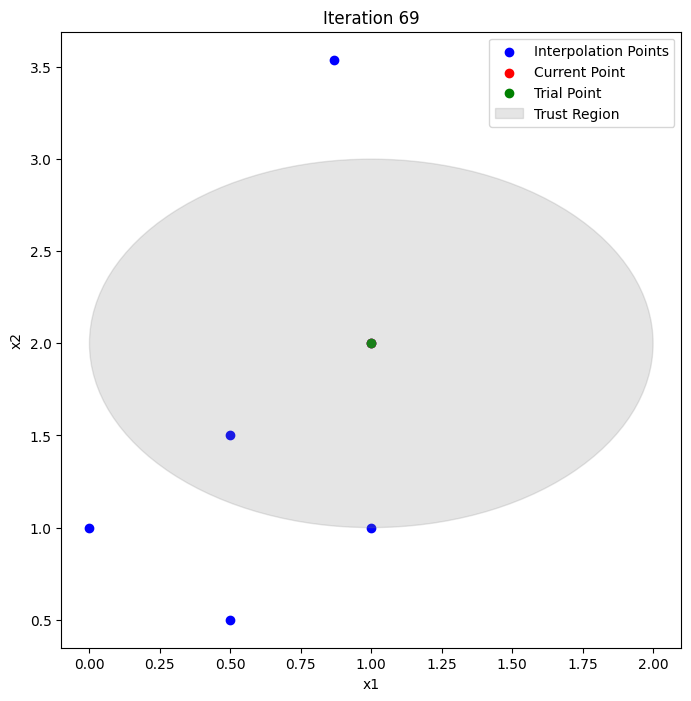

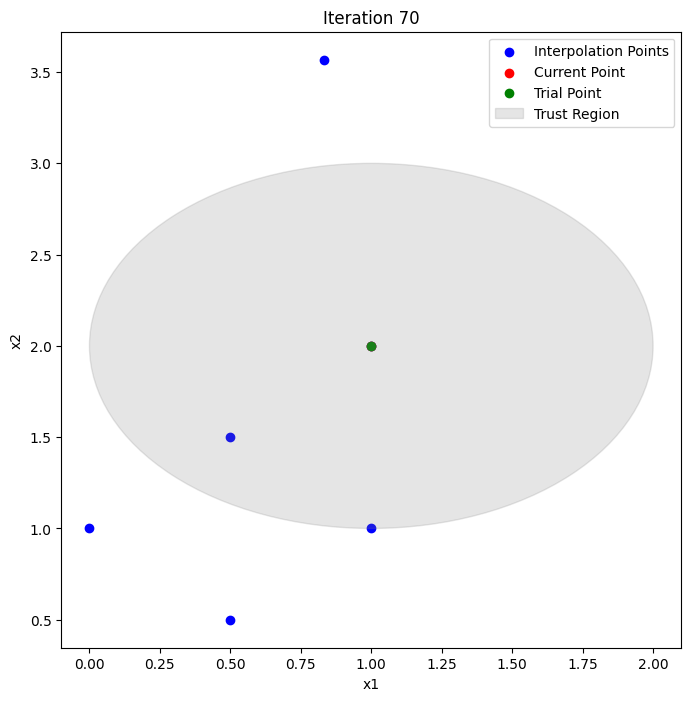

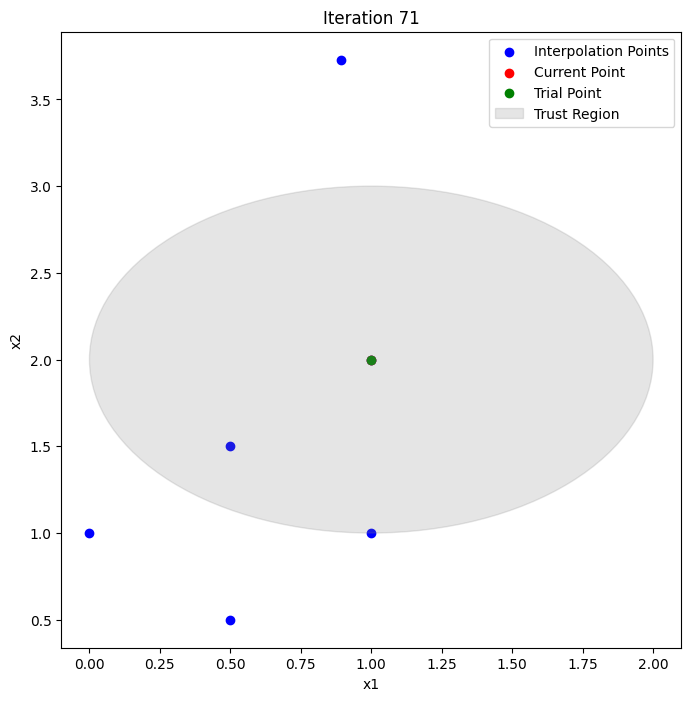

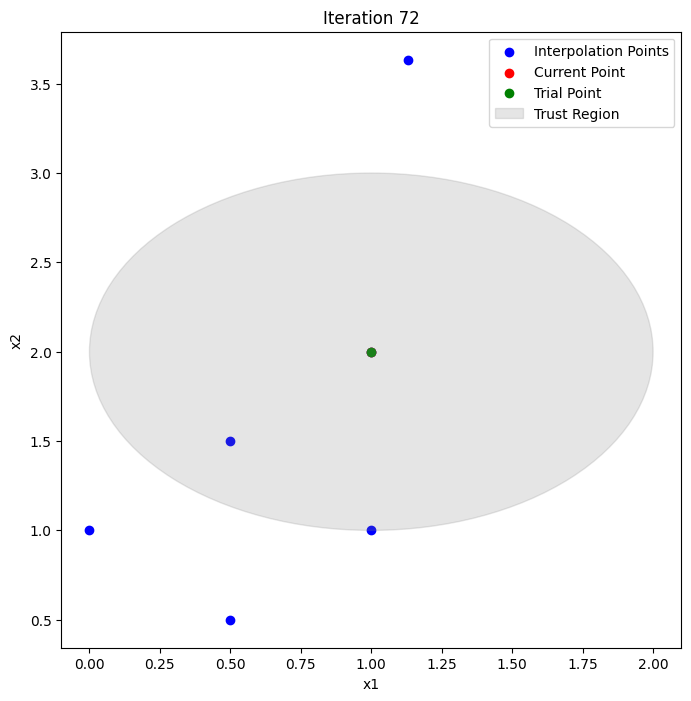

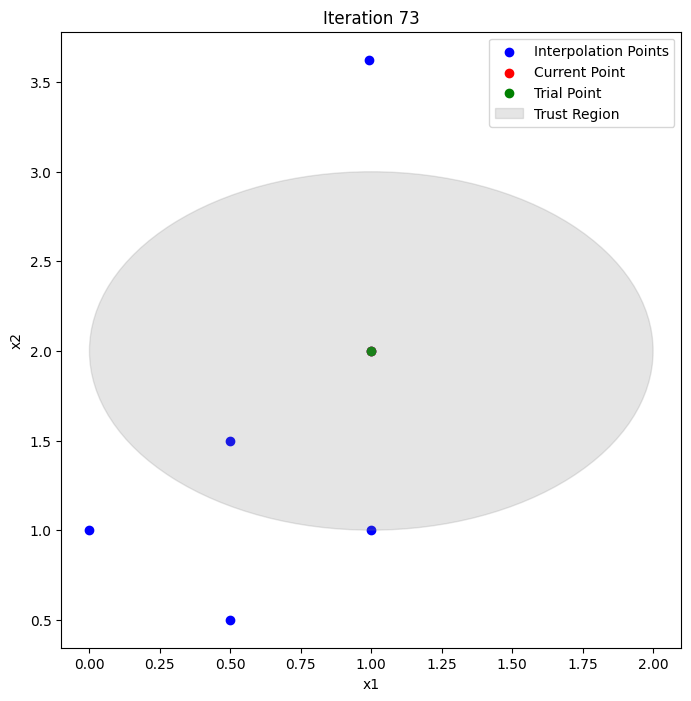

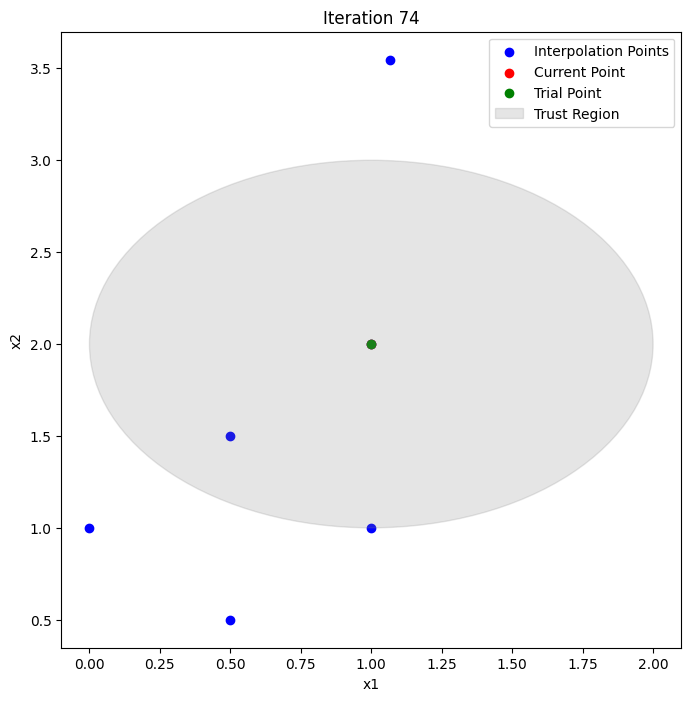

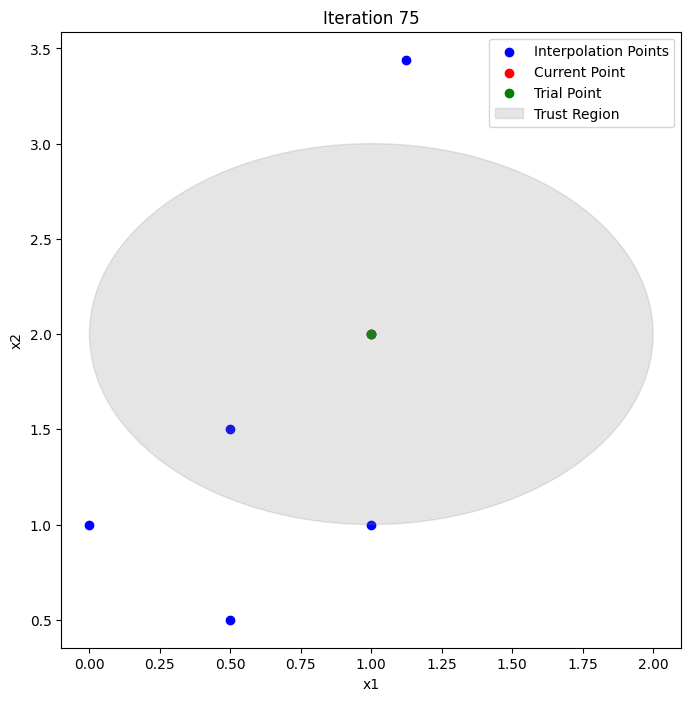

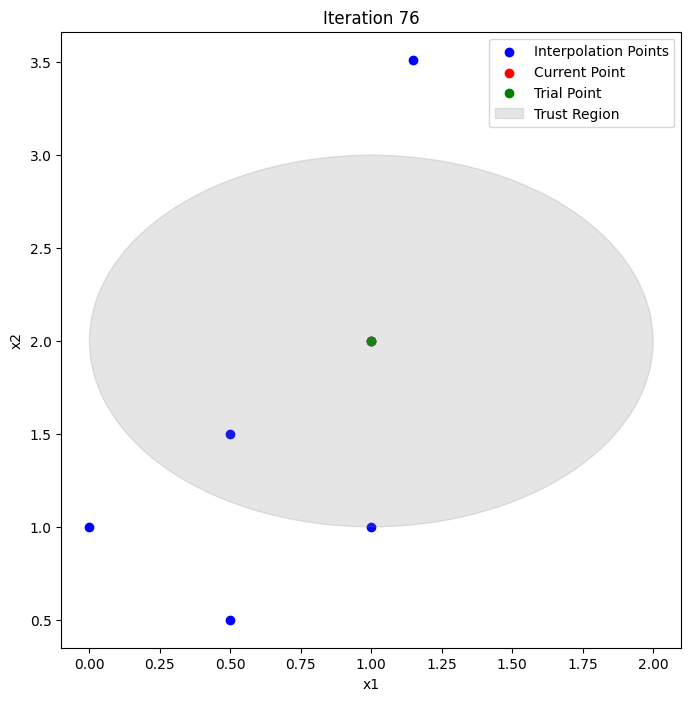

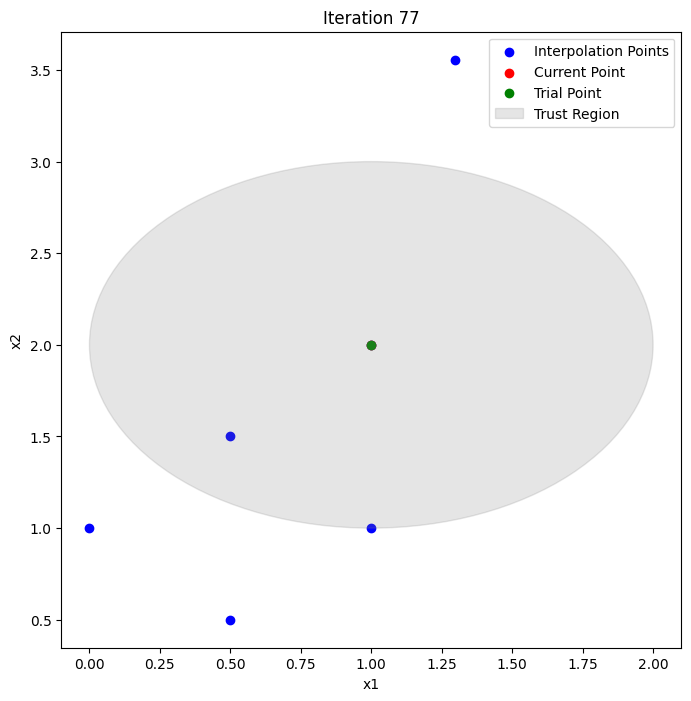

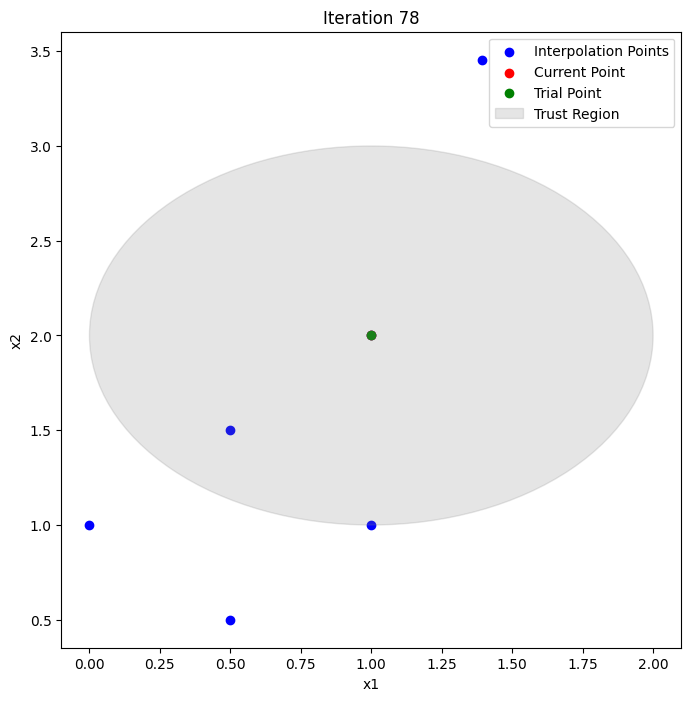

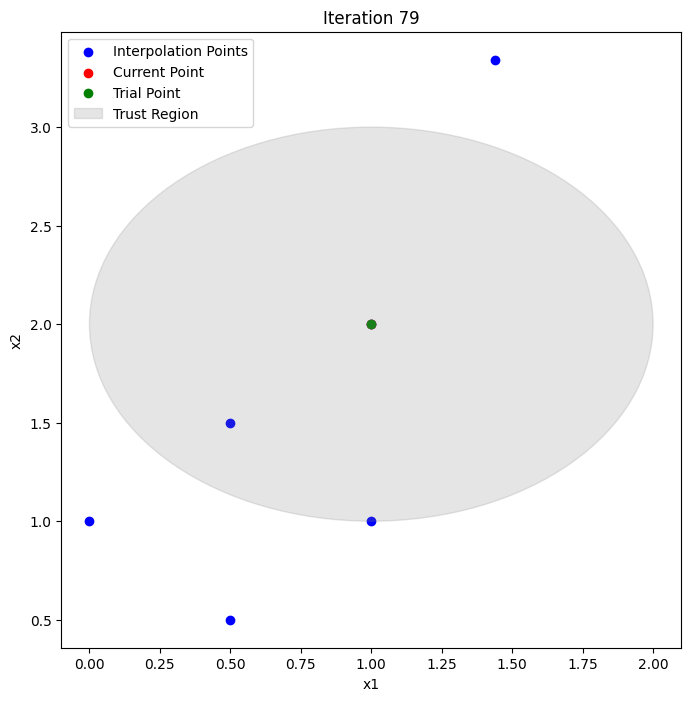

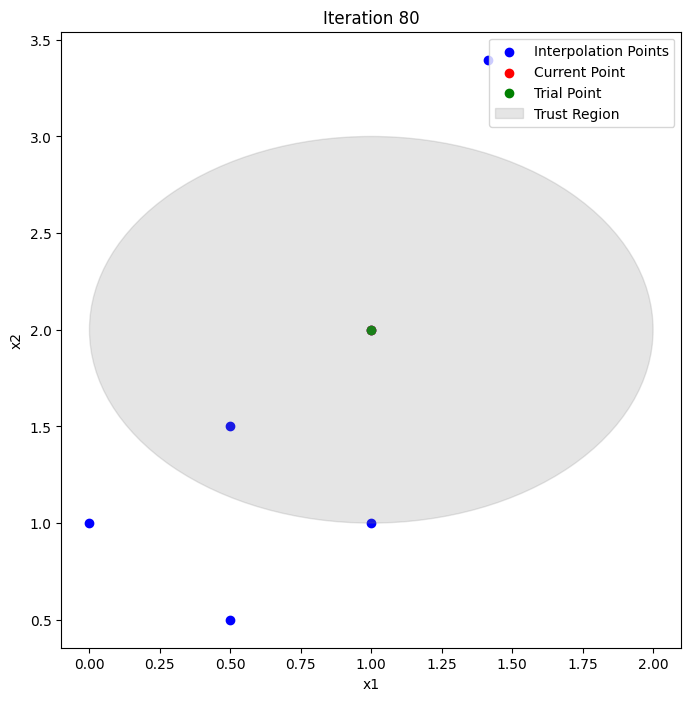

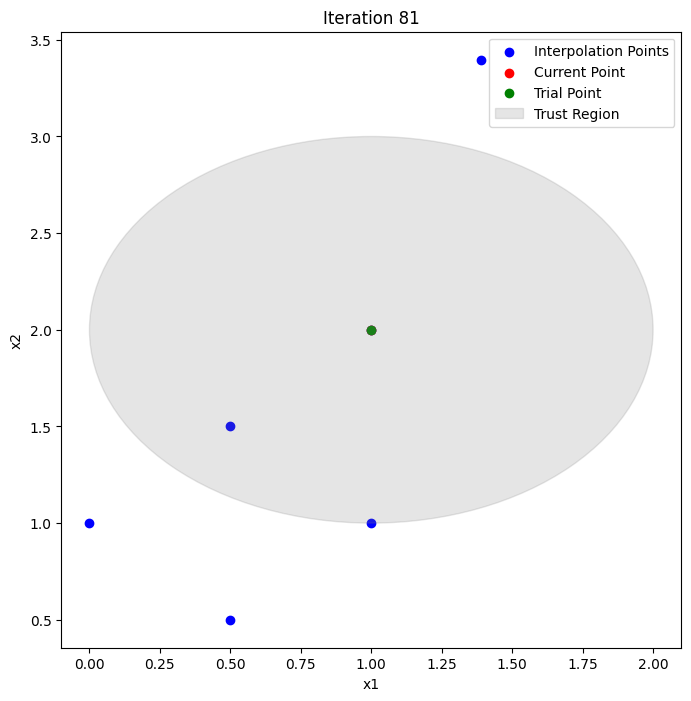

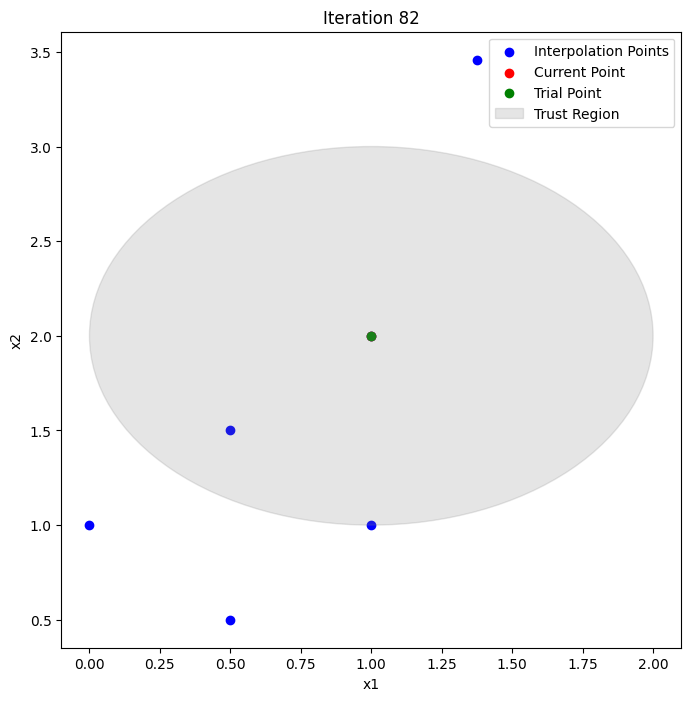

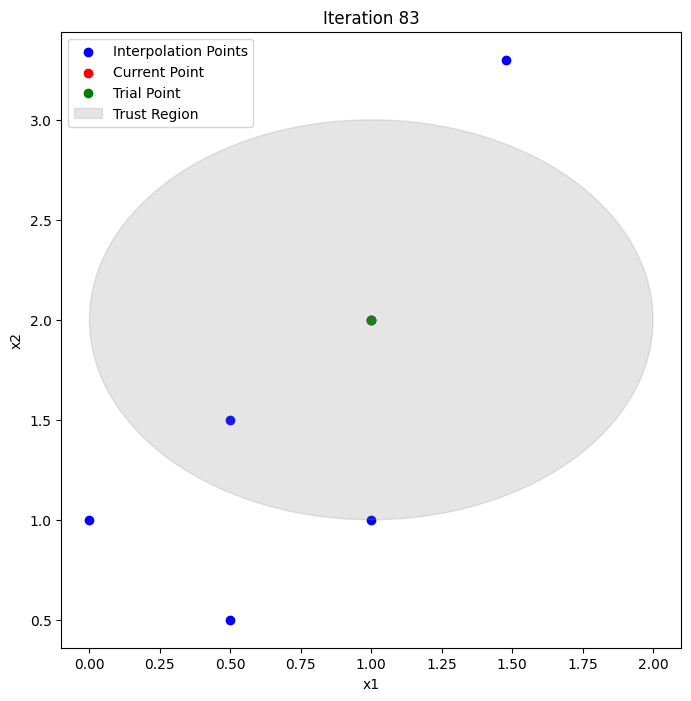

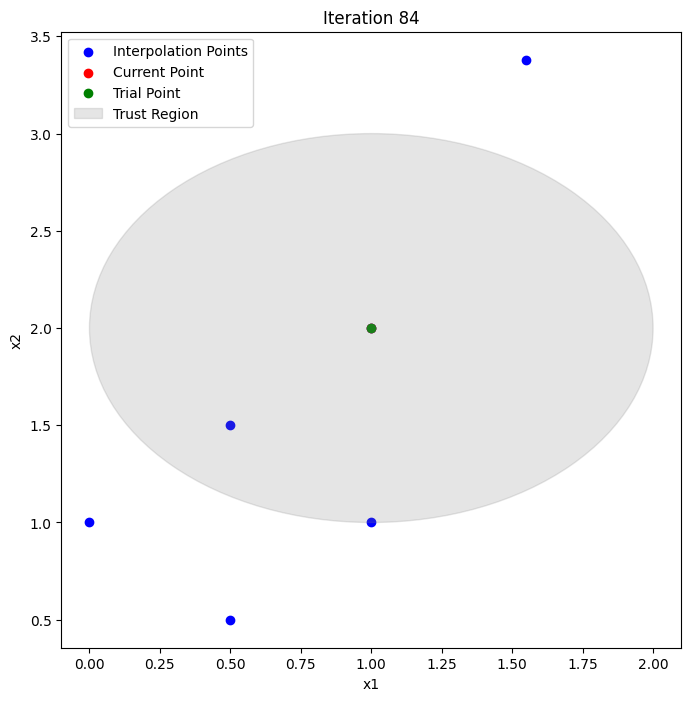

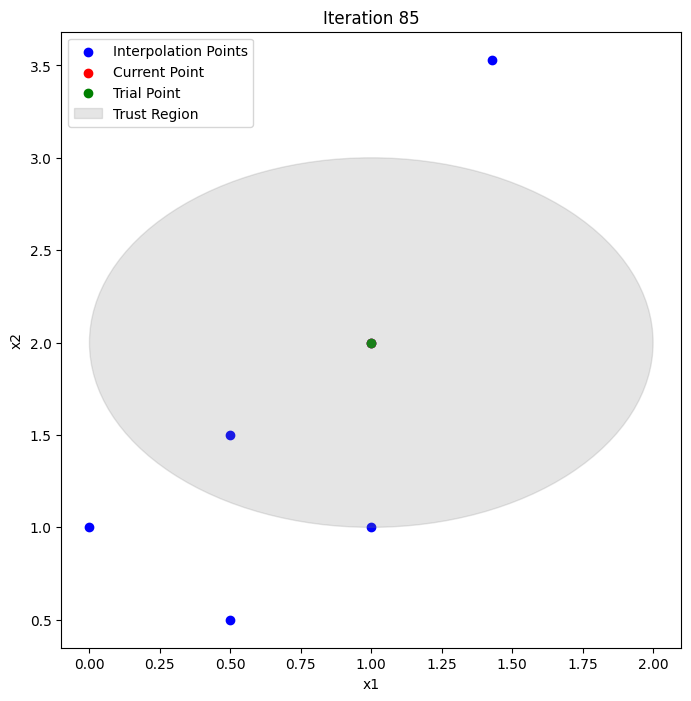

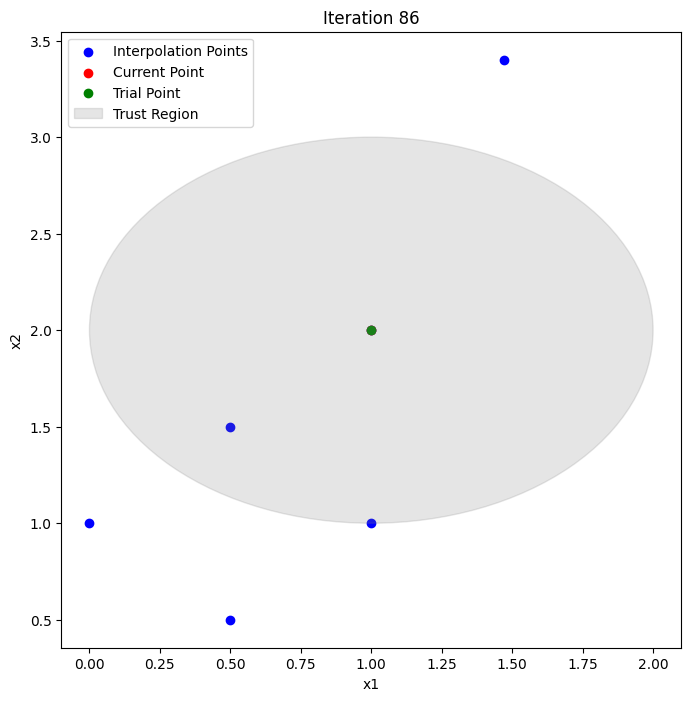

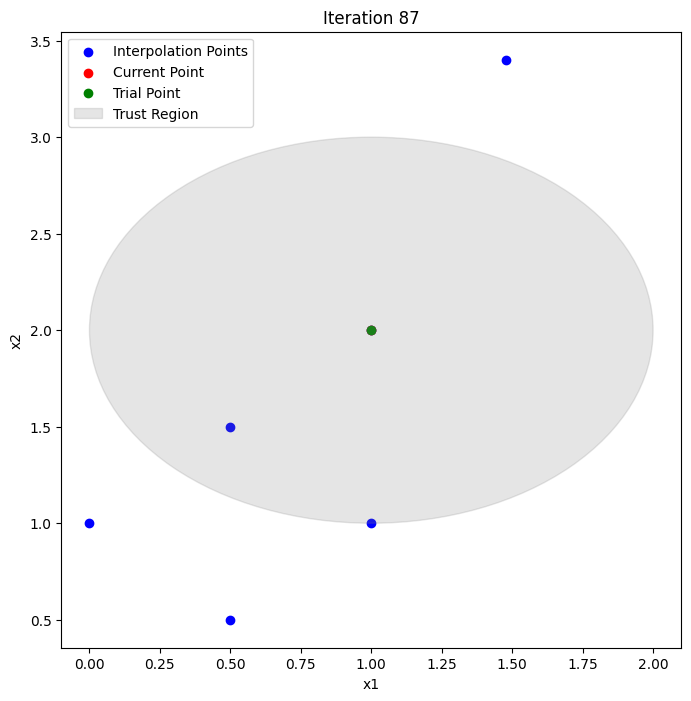

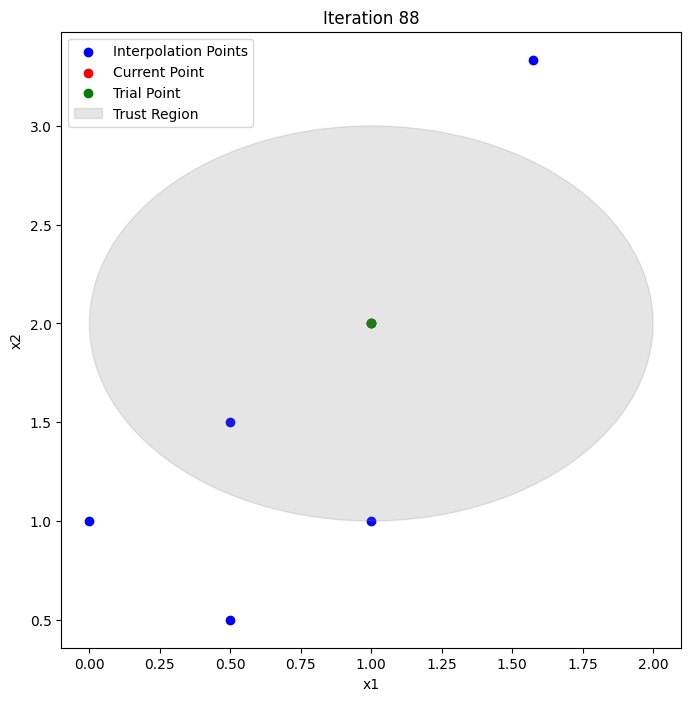

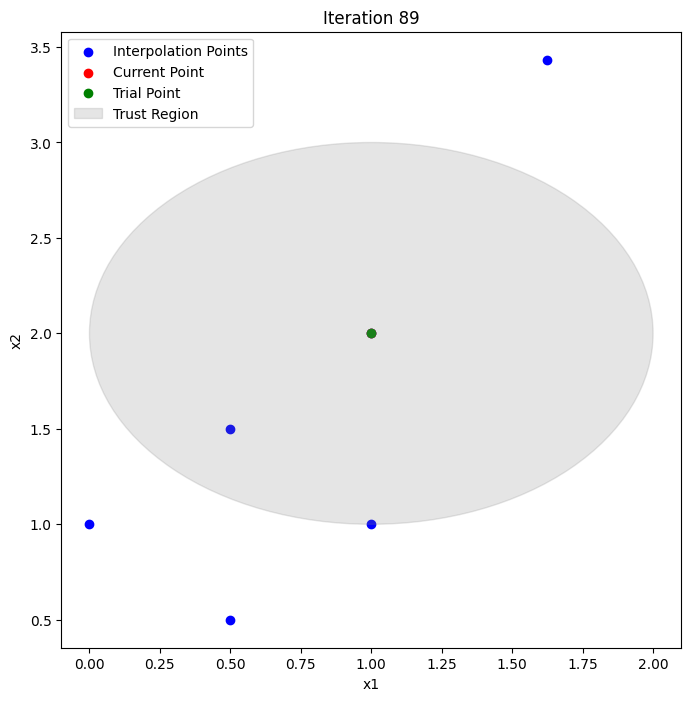

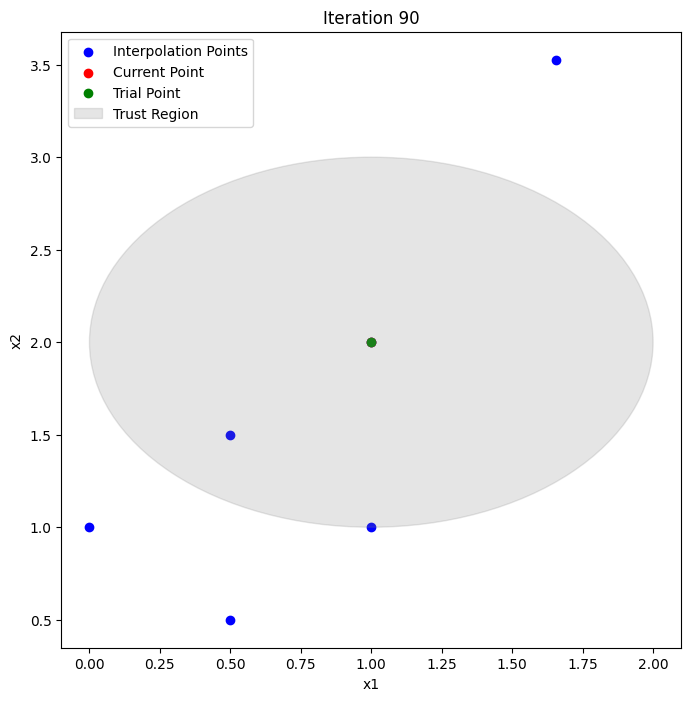

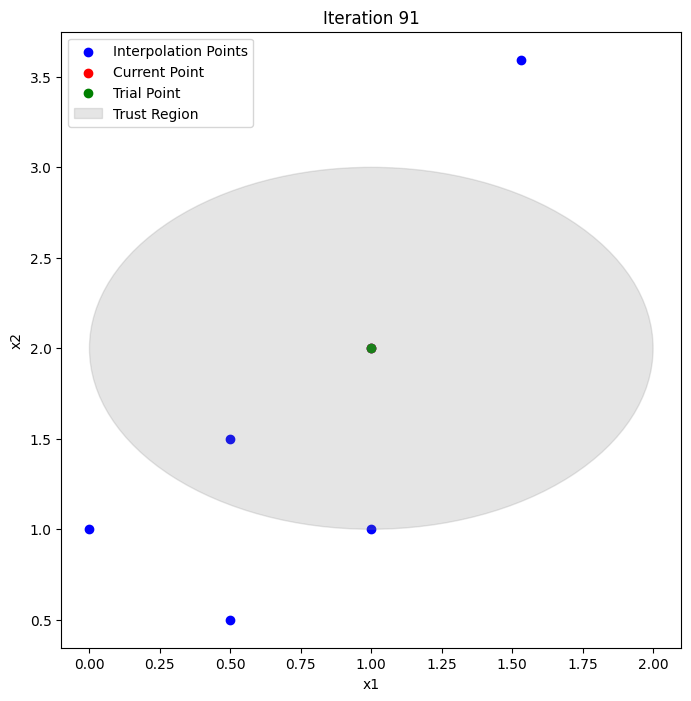

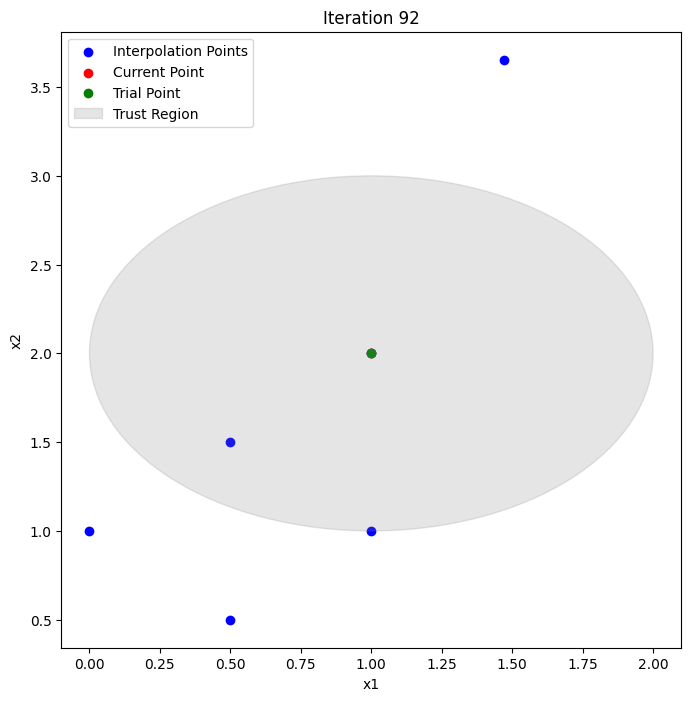

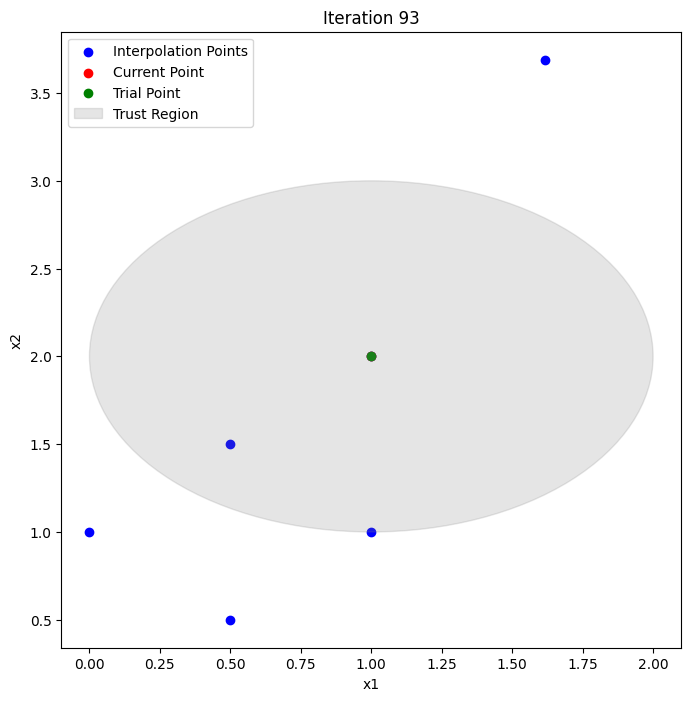

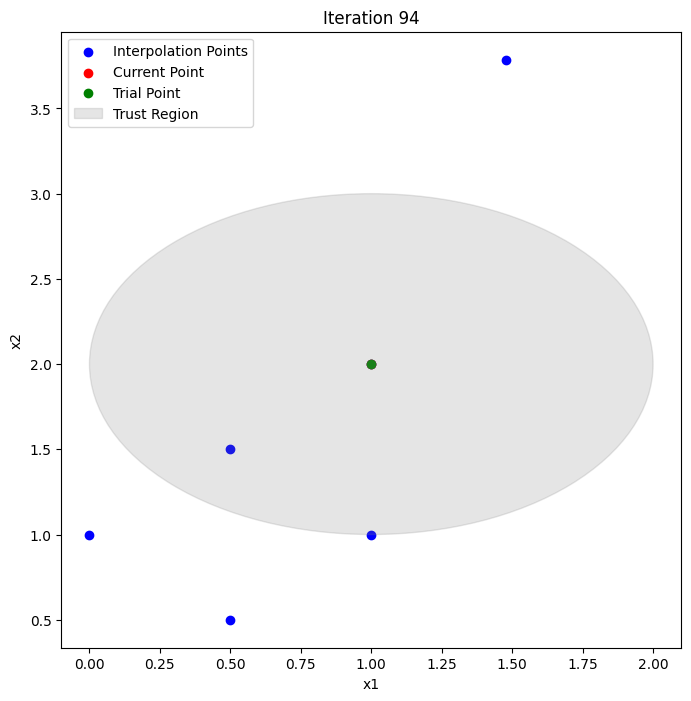

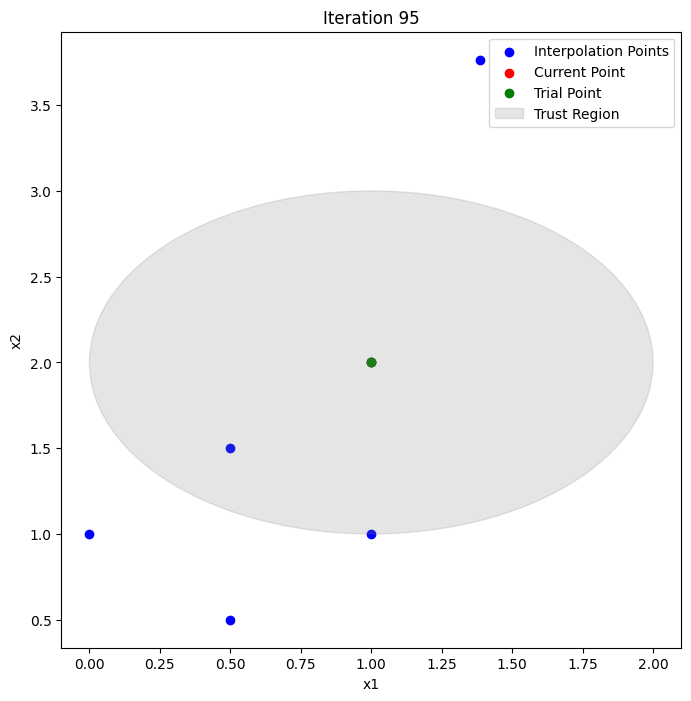

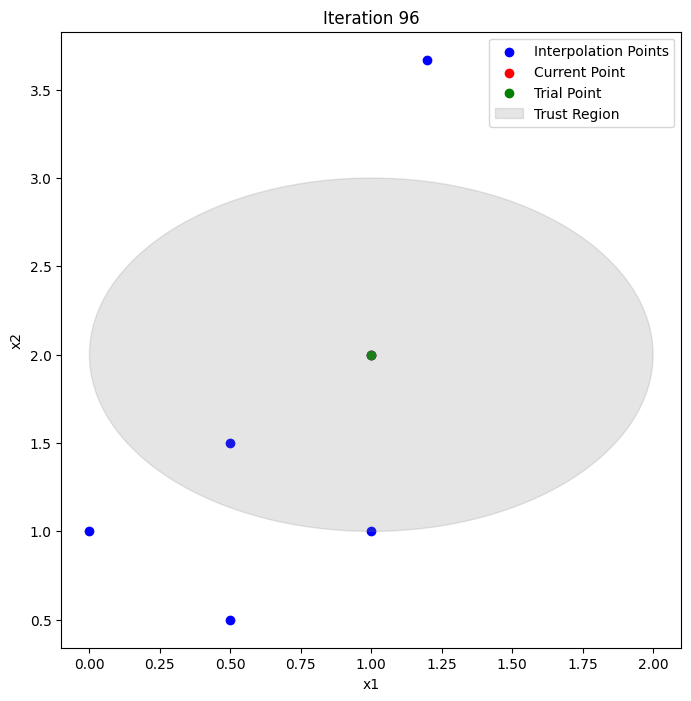

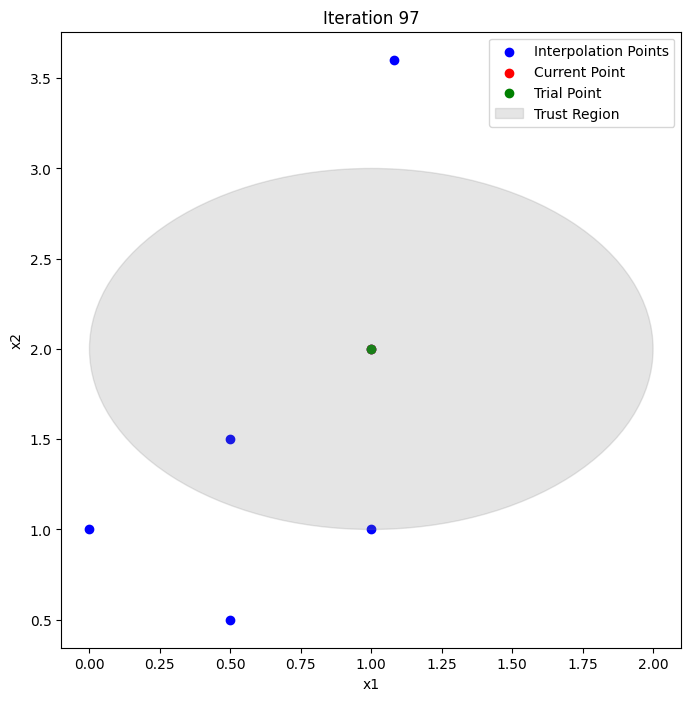

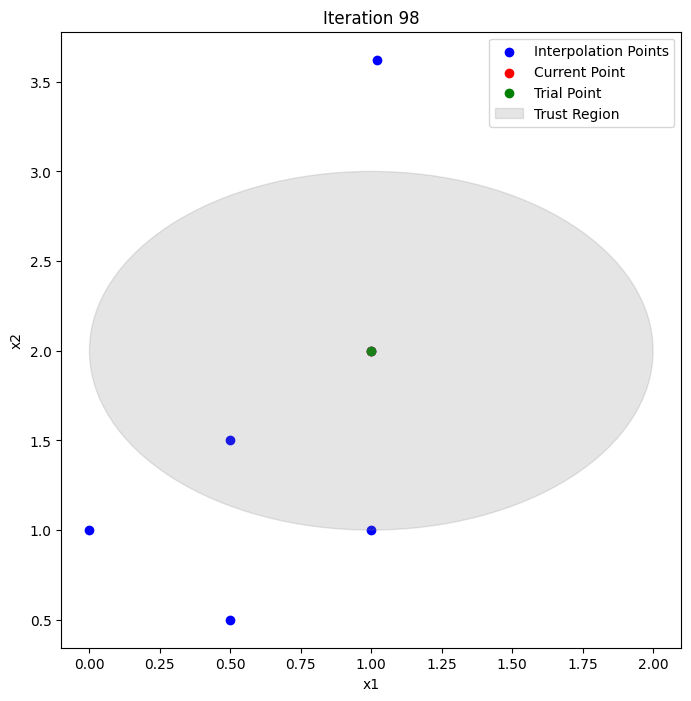

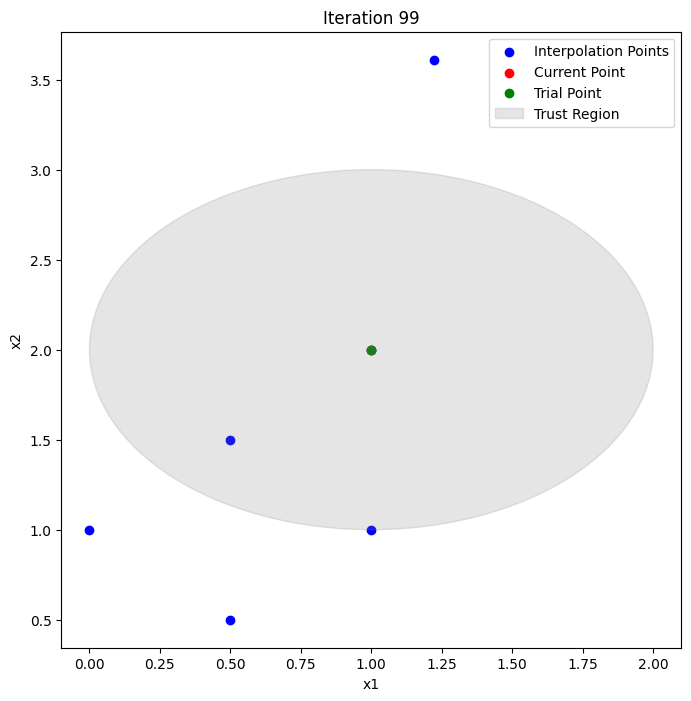

Optimal x: [0.99999999 2.00000001]
Optimal f(x): 3.1204984448215486e-16


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import solve

def quadratic_model(Y, f_values):
    q = len(Y)
    n = len(Y[0])
    required_points = (n + 1) * (n + 2) // 2
    if q < required_points:
        raise ValueError(f"Not enough interpolation points. Need at least {required_points}, but got {q}.")

    A = np.zeros((q, required_points))
    for i in range(q):
        row = [1] + list(Y[i]) + [Y[i][j] * Y[i][k] for j in range(n) for k in range(j, n)]
        A[i, :] = row
    
    coefs = solve(A, f_values)
    return coefs

def model_value(coefs, x):
    n = len(x)
    terms = [1] + list(x) + [x[j] * x[k] for j in range(n) for k in range(j, n)]
    return np.dot(coefs, terms)

def trust_region_subproblem(coefs, xk, delta):
    def model_p(p):
        return model_value(coefs, xk + p)
    
    bounds = [(-delta, delta)] * len(xk)
    res = minimize(model_p, np.zeros_like(xk), bounds=bounds)
    return res.x

def compute_rho(f, xk, pk, mk, f_values, coefs):
    actual_reduction = f(xk) - f(xk + pk)
    predicted_reduction = mk - model_value(coefs, xk + pk)
    return actual_reduction / predicted_reduction if predicted_reduction != 0 else 0

def geometry_improving_procedure(Y):
    perturbed_Y = Y.copy()
    perturbed_Y[0] = Y[0] + 0.1 * np.random.randn(*Y[0].shape)
    return perturbed_Y

def condition_to_check_Y(Y):
    n = len(Y)
    distances = [np.linalg.norm(Y[i] - Y[j]) for i in range(n) for j in range(i + 1, n)]
    return np.min(distances) < 1e-3

def plot_iteration(Y, xk, xk_plus, delta, k, f):
    plt.figure(figsize=(8, 8))
    plt.scatter(*zip(*Y), c='blue', label='Interpolation Points')
    plt.scatter(*xk, c='red', label='Current Point')
    plt.scatter(*xk_plus, c='green', label='Trial Point')
    plt.gca().add_patch(plt.Circle(xk, delta, color='gray', alpha=0.2, label='Trust Region'))
    plt.title(f"Iteration {k}")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.show()

def derivative_free_optimization(f, Y, delta0, eta, max_iter=100):
    xk = min(Y, key=f)
    delta = delta0
    k = 0
    f_values = np.array([f(y) for y in Y])
    
    while k < max_iter:
        coefs = quadratic_model(Y, f_values)
        mk = model_value(coefs, xk)
        
        pk = trust_region_subproblem(coefs, xk, delta)
        xk_plus = xk + pk
        
        rho = compute_rho(f, xk, pk, mk, f_values, coefs)
        
        plot_iteration(Y, xk, xk_plus, delta, k, f)
        
        if rho >= eta:
            Y[np.argmax(f_values)] = xk_plus
            f_values = np.array([f(y) for y in Y])
            delta = max(delta, delta0)
            xk = xk_plus
        else:
            if condition_to_check_Y(Y):
                delta = delta * 0.5
                k += 1
                continue
            
            Y = geometry_improving_procedure(Y)
            f_values = np.array([f(y) for y in Y])
            xk = min(Y, key=f)
            coefs = quadratic_model(Y, f_values)
            rho = compute_rho(f, xk, pk, mk, f_values, coefs)
            
            if rho >= eta:
                xk = xk_plus
        
        k += 1
    
    return xk

# Example usage
f = lambda x: (x[0] - 1)**2 + (x[1] - 2)**2  # Objective function
Y = [np.array([0, 0]), np.array([1, 0]), np.array([0, 1]), np.array([1, 1]),
     np.array([0.5, 0.5]), np.array([0.5, 1.5])]  # Interpolation set
delta0 = 1.0  # Initial trust region radius
eta = 0.1  # Constant

optimal_x = derivative_free_optimization(f, Y, delta0, eta)
print("Optimal x:", optimal_x)
print("Optimal f(x):", f(optimal_x))


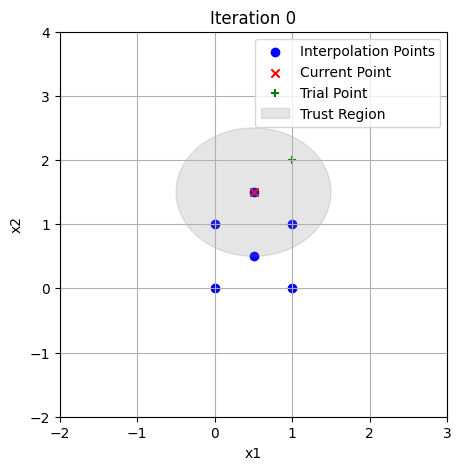

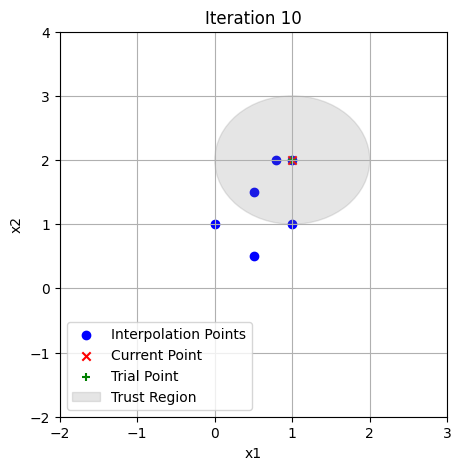

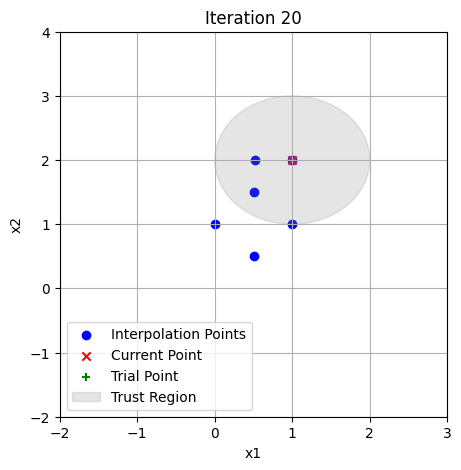

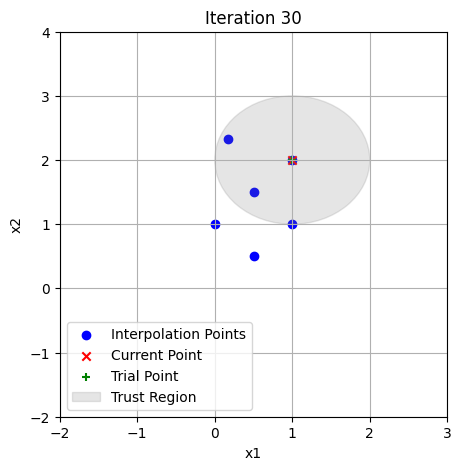

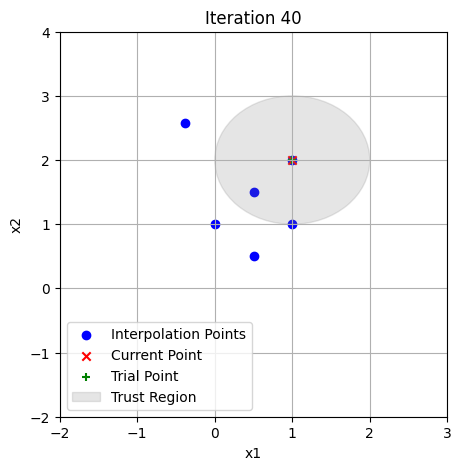

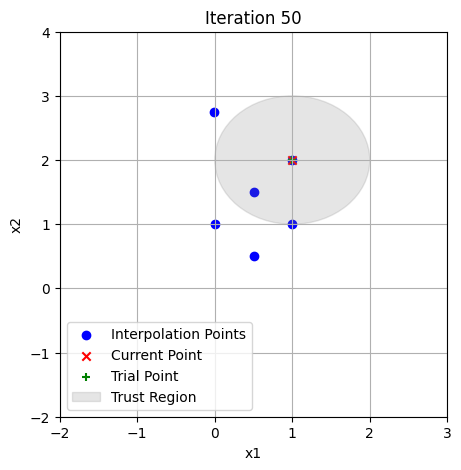

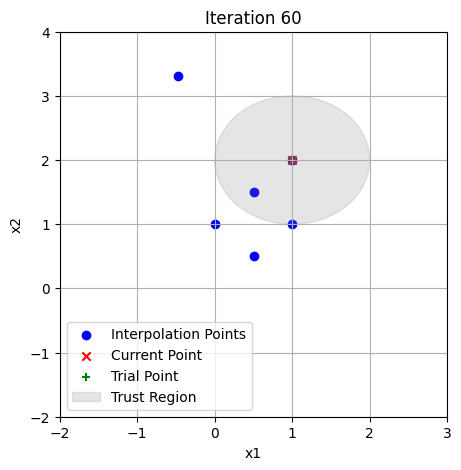

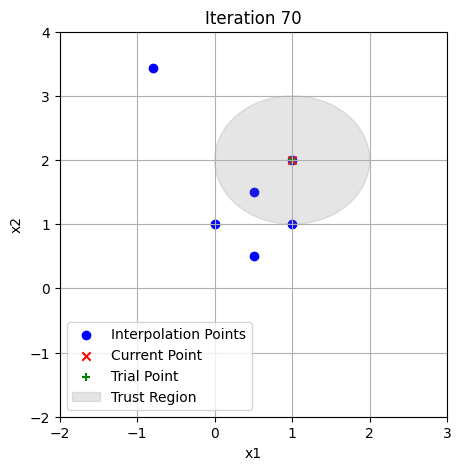

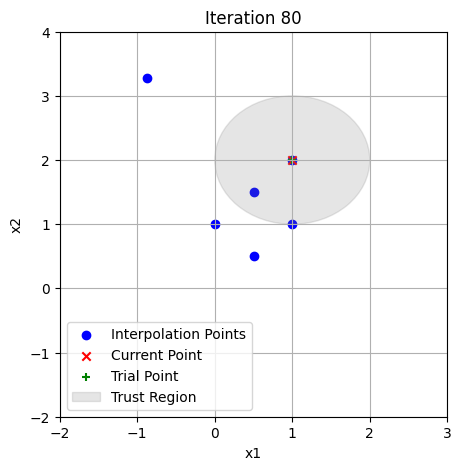

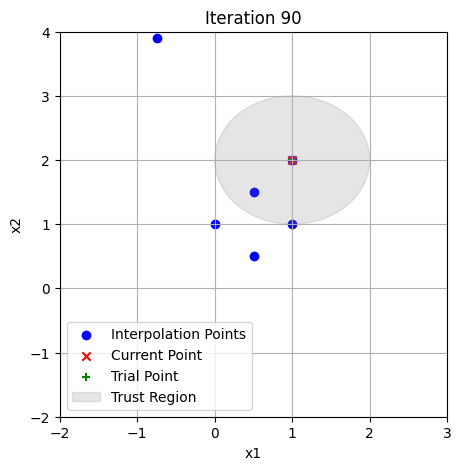

Optimal x: [0.99999998 1.99999998]
Optimal f(x): 8.439692343680219e-16


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import solve

def quadratic_model(Y, f_values):
    q = len(Y)
    n = len(Y[0])
    required_points = (n + 1) * (n + 2) // 2
    if q < required_points:
        raise ValueError(f"Not enough interpolation points. Need at least {required_points}, but got {q}.")

    A = np.zeros((q, required_points))
    for i in range(q):
        row = [1] + list(Y[i]) + [Y[i][j] * Y[i][k] for j in range(n) for k in range(j, n)]
        A[i, :] = row
    
    coefs = solve(A, f_values)
    return coefs

def model_value(coefs, x):
    n = len(x)
    terms = [1] + list(x) + [x[j] * x[k] for j in range(n) for k in range(j, n)]
    return np.dot(coefs, terms)

def trust_region_subproblem(coefs, xk, delta):
    def model_p(p):
        return model_value(coefs, xk + p)
    
    bounds = [(-delta, delta)] * len(xk)
    res = minimize(model_p, np.zeros_like(xk), bounds=bounds)
    return res.x

def compute_rho(f, xk, pk, mk, f_values, coefs):
    actual_reduction = f(xk) - f(xk + pk)
    predicted_reduction = mk - model_value(coefs, xk + pk)
    return actual_reduction / predicted_reduction if predicted_reduction != 0 else 0

def geometry_improving_procedure(Y):
    perturbed_Y = Y.copy()
    perturbed_Y[0] = Y[0] + 0.1 * np.random.randn(*Y[0].shape)
    return perturbed_Y

def condition_to_check_Y(Y):
    n = len(Y)
    distances = [np.linalg.norm(Y[i] - Y[j]) for i in range(n) for j in range(i + 1, n)]
    return np.min(distances) < 1e-3

def plot_iteration(Y, xk, xk_plus, delta, k, f):
    plt.figure(figsize=(5, 5))
    plt.scatter(*zip(*Y), c='blue', label='Interpolation Points')
    plt.scatter(*xk, c='red', label='Current Point', marker='x')
    plt.scatter(*xk_plus, c='green', label='Trial Point', marker='+')
    circle = plt.Circle(xk, delta, color='gray', alpha=0.2, label='Trust Region')
    plt.gca().add_patch(circle)
    plt.title(f"Iteration {k}")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.xlim(-2, 3)
    plt.ylim(-2, 4)
    plt.grid(True)
    plt.show()

def derivative_free_optimization(f, Y, delta0, eta, max_iter=100):
    xk = min(Y, key=f)
    delta = delta0
    k = 0
    f_values = np.array([f(y) for y in Y])
    
    while k < max_iter:
        coefs = quadratic_model(Y, f_values)
        mk = model_value(coefs, xk)
        
        pk = trust_region_subproblem(coefs, xk, delta)
        xk_plus = xk + pk
        
        rho = compute_rho(f, xk, pk, mk, f_values, coefs)
        
        if k % 10 == 0:
            plot_iteration(Y, xk, xk_plus, delta, k, f)
        
        if rho >= eta:
            Y[np.argmax(f_values)] = xk_plus
            f_values = np.array([f(y) for y in Y])
            delta = max(delta, delta0)
            xk = xk_plus
        else:
            if condition_to_check_Y(Y):
                delta = delta * 0.5
                k += 1
                continue
            
            Y = geometry_improving_procedure(Y)
            f_values = np.array([f(y) for y in Y])
            xk = min(Y, key=f)
            coefs = quadratic_model(Y, f_values)
            rho = compute_rho(f, xk, pk, mk, f_values, coefs)
            
            if rho >= eta:
                xk = xk_plus
        
        k += 1
    
    return xk

# Example usage
f = lambda x: (x[0] - 1)**2 + (x[1] - 2)**2  # Objective function
Y = [np.array([0, 0]), np.array([1, 0]), np.array([0, 1]), np.array([1, 1]),
     np.array([0.5, 0.5]), np.array([0.5, 1.5])]  # Interpolation set
delta0 = 1.0  # Initial trust region radius
eta = 0.1  # Constant

optimal_x = derivative_free_optimization(f, Y, delta0, eta)
print("Optimal x:", optimal_x)
print("Optimal f(x):", f(optimal_x))


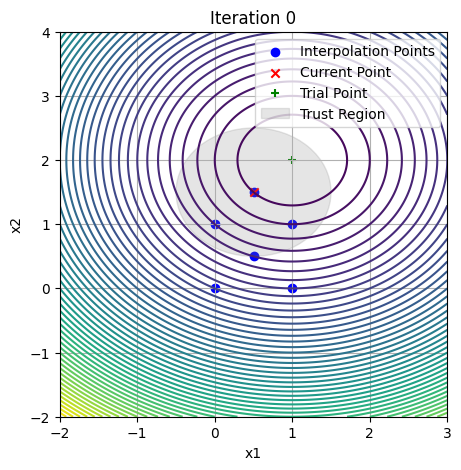

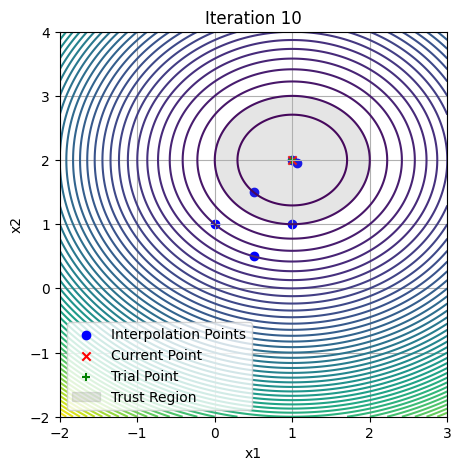

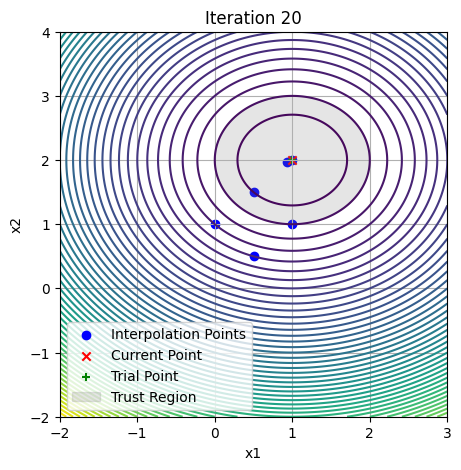

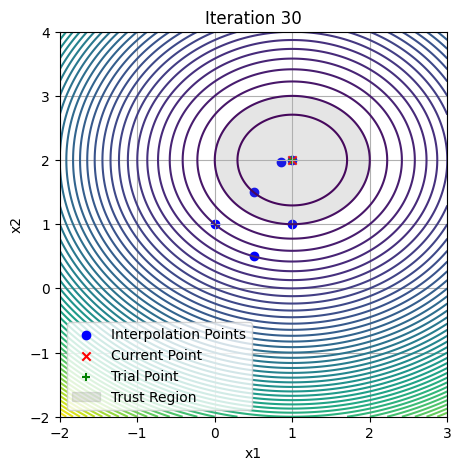

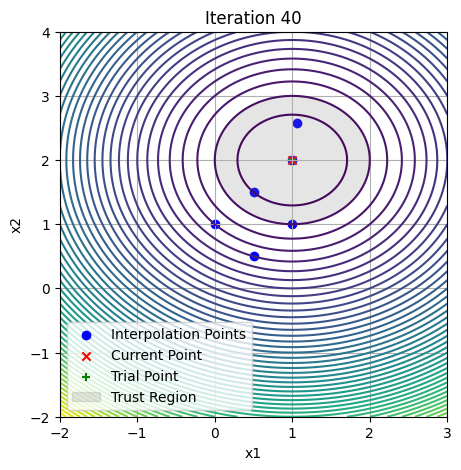

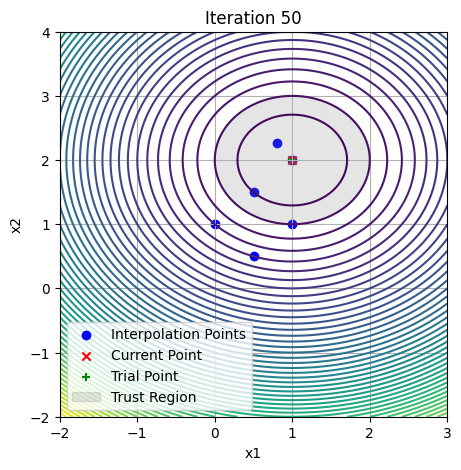

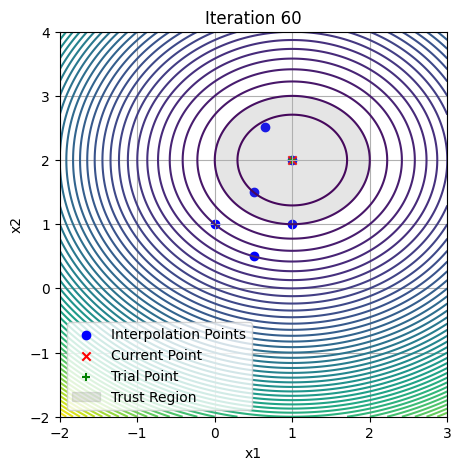

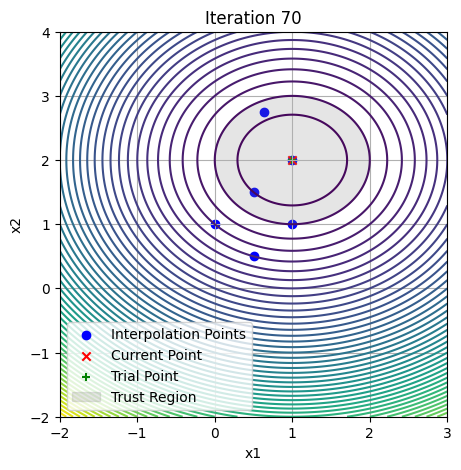

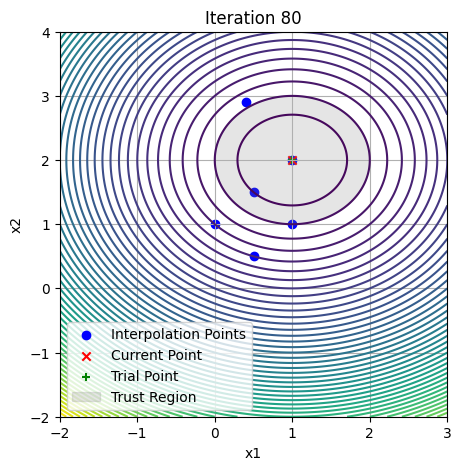

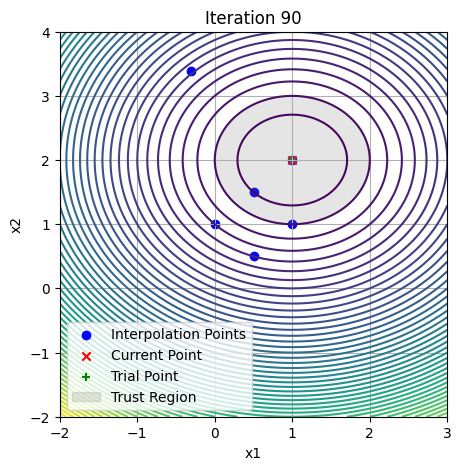

Optimal x: [1.00000001 1.99999999]
Optimal f(x): 2.6089392735547513e-16


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import solve

def quadratic_model(Y, f_values):
    q = len(Y)
    n = len(Y[0])
    required_points = (n + 1) * (n + 2) // 2
    if q < required_points:
        raise ValueError(f"Not enough interpolation points. Need at least {required_points}, but got {q}.")

    A = np.zeros((q, required_points))
    for i in range(q):
        row = [1] + list(Y[i]) + [Y[i][j] * Y[i][k] for j in range(n) for k in range(j, n)]
        A[i, :] = row
    
    coefs = solve(A, f_values)
    return coefs

def model_value(coefs, x):
    n = len(x)
    terms = [1] + list(x) + [x[j] * x[k] for j in range(n) for k in range(j, n)]
    return np.dot(coefs, terms)

def trust_region_subproblem(coefs, xk, delta):
    def model_p(p):
        return model_value(coefs, xk + p)
    
    bounds = [(-delta, delta)] * len(xk)
    res = minimize(model_p, np.zeros_like(xk), bounds=bounds)
    return res.x

def compute_rho(f, xk, pk, mk, f_values, coefs):
    actual_reduction = f(xk) - f(xk + pk)
    predicted_reduction = mk - model_value(coefs, xk + pk)
    return actual_reduction / predicted_reduction if predicted_reduction != 0 else 0

def geometry_improving_procedure(Y):
    perturbed_Y = Y.copy()
    perturbed_Y[0] = Y[0] + 0.1 * np.random.randn(*Y[0].shape)
    return perturbed_Y

def condition_to_check_Y(Y):
    n = len(Y)
    distances = [np.linalg.norm(Y[i] - Y[j]) for i in range(n) for j in range(i + 1, n)]
    return np.min(distances) < 1e-3

def plot_iteration(Y, xk, xk_plus, delta, k, f):
    plt.figure(figsize=(5, 5))
    
    # Plot the objective function contour
    x1_range = np.linspace(-2, 3, 400)
    x2_range = np.linspace(-2, 4, 400)
    X1, X2 = np.meshgrid(x1_range, x2_range)
    Z = np.array([[f([x1, x2]) for x1 in x1_range] for x2 in x2_range])
    plt.contour(X1, X2, Z, levels=50, cmap='viridis')
    
    plt.scatter(*zip(*Y), c='blue', label='Interpolation Points')
    plt.scatter(*xk, c='red', label='Current Point', marker='x')
    plt.scatter(*xk_plus, c='green', label='Trial Point', marker='+')
    circle = plt.Circle(xk, delta, color='gray', alpha=0.2, label='Trust Region')
    plt.gca().add_patch(circle)
    plt.title(f"Iteration {k}")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.xlim(-2, 3)
    plt.ylim(-2, 4)
    plt.grid(True)
    plt.show()

def derivative_free_optimization(f, Y, delta0, eta, max_iter=100):
    xk = min(Y, key=f)
    delta = delta0
    k = 0
    f_values = np.array([f(y) for y in Y])
    
    while k < max_iter:
        coefs = quadratic_model(Y, f_values)
        mk = model_value(coefs, xk)
        
        pk = trust_region_subproblem(coefs, xk, delta)
        xk_plus = xk + pk
        
        rho = compute_rho(f, xk, pk, mk, f_values, coefs)
        
        if k % 10 == 0:
            plot_iteration(Y, xk, xk_plus, delta, k, f)
        
        if rho >= eta:
            Y[np.argmax(f_values)] = xk_plus
            f_values = np.array([f(y) for y in Y])
            delta = max(delta, delta0)
            xk = xk_plus
        else:
            if condition_to_check_Y(Y):
                delta = delta * 0.5
                k += 1
                continue
            
            Y = geometry_improving_procedure(Y)
            f_values = np.array([f(y) for y in Y])
            xk = min(Y, key=f)
            coefs = quadratic_model(Y, f_values)
            rho = compute_rho(f, xk, pk, mk, f_values, coefs)
            
            if rho >= eta:
                xk = xk_plus
        
        k += 1
    
    return xk

# Example usage
f = lambda x: (x[0] - 1)**2 + (x[1] - 2)**2  # Objective function
Y = [np.array([0, 0]), np.array([1, 0]), np.array([0, 1]), np.array([1, 1]),
     np.array([0.5, 0.5]), np.array([0.5, 1.5])]  # Interpolation set
delta0 = 1.0  # Initial trust region radius
eta = 0.1  # Constant

optimal_x = derivative_free_optimization(f, Y, delta0, eta)
print("Optimal x:", optimal_x)
print("Optimal f(x):", f(optimal_x))


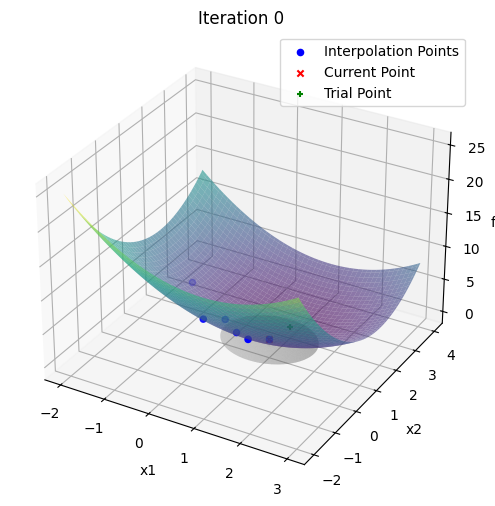

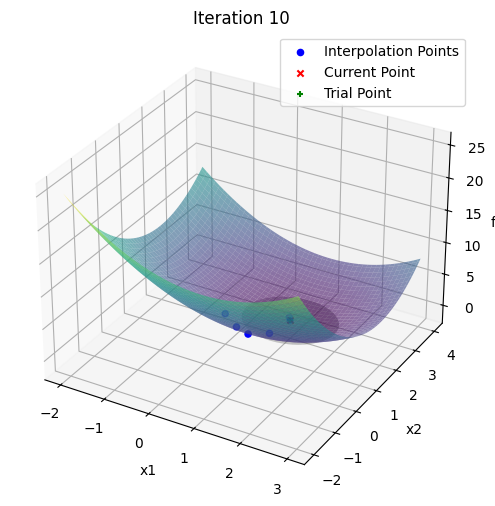

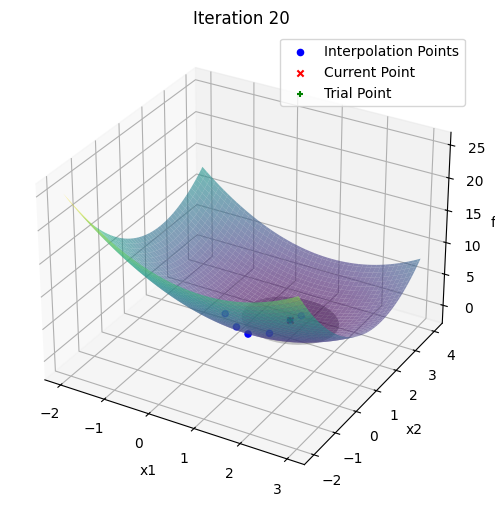

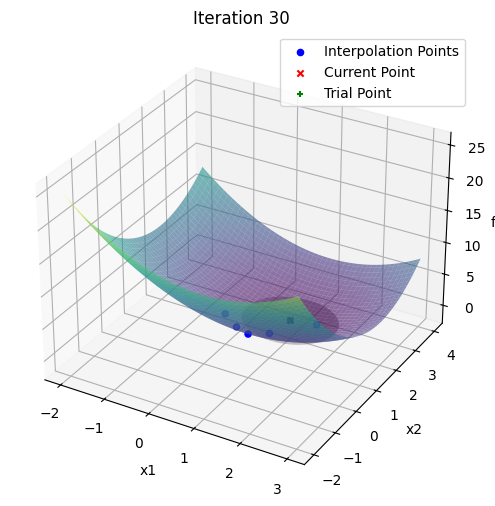

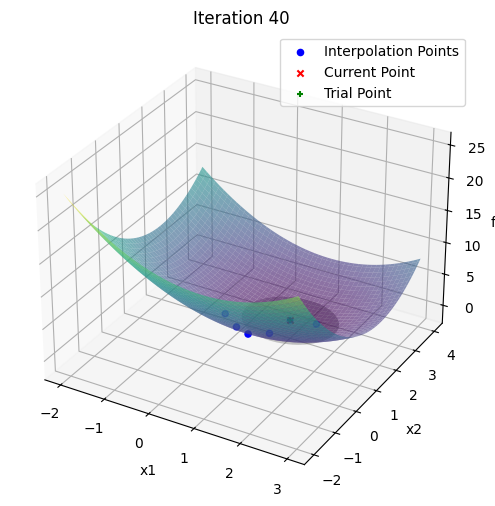

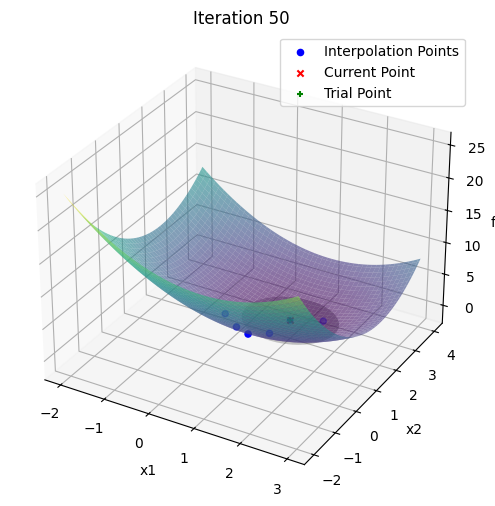

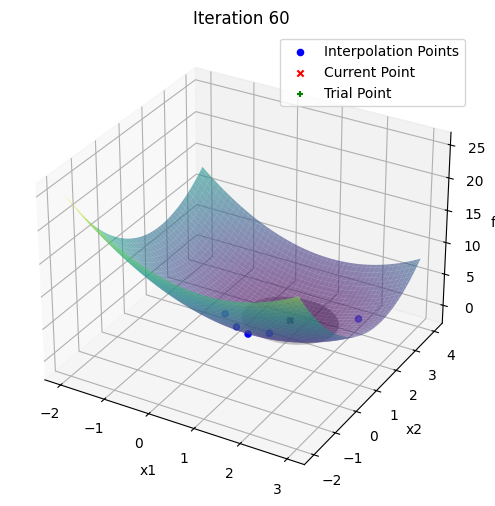

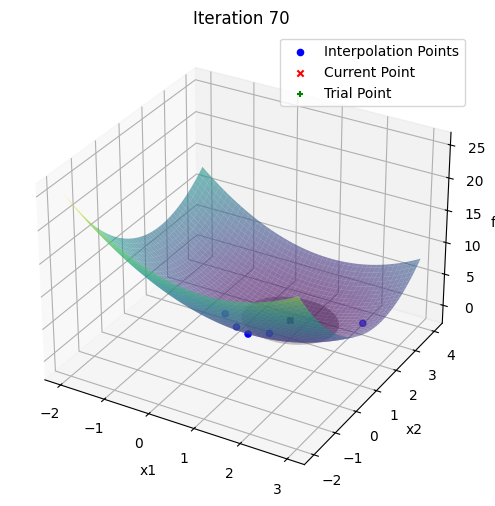

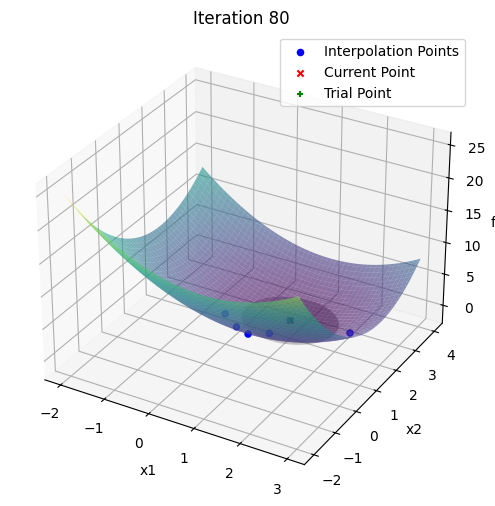

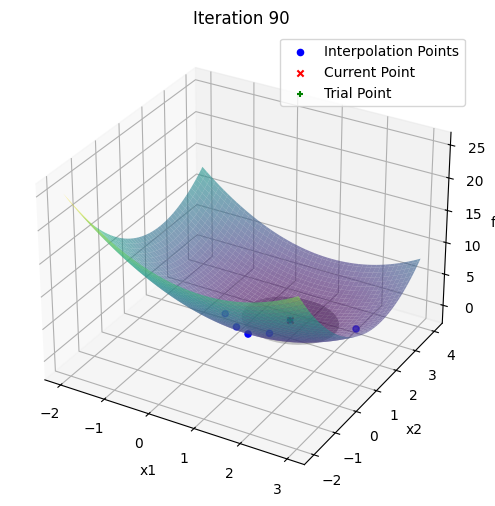

Optimal x: [1.         1.99999999]
Optimal f(x): 1.8525654707039642e-16


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import solve
from mpl_toolkits.mplot3d import Axes3D

def quadratic_model(Y, f_values):
    q = len(Y)
    n = len(Y[0])
    required_points = (n + 1) * (n + 2) // 2
    if q < required_points:
        raise ValueError(f"Not enough interpolation points. Need at least {required_points}, but got {q}.")

    A = np.zeros((q, required_points))
    for i in range(q):
        row = [1] + list(Y[i]) + [Y[i][j] * Y[i][k] for j in range(n) for k in range(j, n)]
        A[i, :] = row
    
    coefs = solve(A, f_values)
    return coefs

def model_value(coefs, x):
    n = len(x)
    terms = [1] + list(x) + [x[j] * x[k] for j in range(n) for k in range(j, n)]
    return np.dot(coefs, terms)

def trust_region_subproblem(coefs, xk, delta):
    def model_p(p):
        return model_value(coefs, xk + p)
    
    bounds = [(-delta, delta)] * len(xk)
    res = minimize(model_p, np.zeros_like(xk), bounds=bounds)
    return res.x

def compute_rho(f, xk, pk, mk, f_values, coefs):
    actual_reduction = f(xk) - f(xk + pk)
    predicted_reduction = mk - model_value(coefs, xk + pk)
    return actual_reduction / predicted_reduction if predicted_reduction != 0 else 0

def geometry_improving_procedure(Y):
    perturbed_Y = Y.copy()
    perturbed_Y[0] = Y[0] + 0.1 * np.random.randn(*Y[0].shape)
    return perturbed_Y

def condition_to_check_Y(Y):
    n = len(Y)
    distances = [np.linalg.norm(Y[i] - Y[j]) for i in range(n) for j in range(i + 1, n)]
    return np.min(distances) < 1e-3

def plot_iteration(Y, xk, xk_plus, delta, k, f):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the objective function surface
    x1_range = np.linspace(-2, 3, 100)
    x2_range = np.linspace(-2, 4, 100)
    X1, X2 = np.meshgrid(x1_range, x2_range)
    Z = np.array([[f([x1, x2]) for x1 in x1_range] for x2 in x2_range])
    ax.plot_surface(X1, X2, Z, cmap='viridis', alpha=0.6)
    
    Y_array = np.array(Y)
    ax.scatter(Y_array[:, 0], Y_array[:, 1], [f(y) for y in Y], c='blue', label='Interpolation Points')
    ax.scatter(*xk, f(xk), c='red', label='Current Point', marker='x')
    ax.scatter(*xk_plus, f(xk_plus), c='green', label='Trial Point', marker='+')
    
    # Plot trust region as a sphere in the 3D space
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x_sphere = delta * np.outer(np.cos(u), np.sin(v)) + xk[0]
    y_sphere = delta * np.outer(np.sin(u), np.sin(v)) + xk[1]
    z_sphere = delta * np.outer(np.ones(np.size(u)), np.cos(v)) + f(xk)
    ax.plot_surface(x_sphere, y_sphere, z_sphere, color='gray', alpha=0.2)

    ax.set_title(f"Iteration {k}")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_zlabel("f(x)")
    ax.legend()
    plt.show()

def derivative_free_optimization(f, Y, delta0, eta, max_iter=100):
    xk = min(Y, key=f)
    delta = delta0
    k = 0
    f_values = np.array([f(y) for y in Y])
    
    while k < max_iter:
        coefs = quadratic_model(Y, f_values)
        mk = model_value(coefs, xk)
        
        pk = trust_region_subproblem(coefs, xk, delta)
        xk_plus = xk + pk
        
        rho = compute_rho(f, xk, pk, mk, f_values, coefs)
        
        if k % 10 == 0:
            plot_iteration(Y, xk, xk_plus, delta, k, f)
        
        if rho >= eta:
            Y[np.argmax(f_values)] = xk_plus
            f_values = np.array([f(y) for y in Y])
            delta = max(delta, delta0)
            xk = xk_plus
        else:
            if condition_to_check_Y(Y):
                delta = delta * 0.5
                k += 1
                continue
            
            Y = geometry_improving_procedure(Y)
            f_values = np.array([f(y) for y in Y])
            xk = min(Y, key=f)
            coefs = quadratic_model(Y, f_values)
            rho = compute_rho(f, xk, pk, mk, f_values, coefs)
            
            if rho >= eta:
                xk = xk_plus
        
        k += 1
    
    return xk

# Example usage
f = lambda x: (x[0] - 1)**2 + (x[1] - 2)**2  # Objective function
Y = [np.array([0, 0]), np.array([1, 0]), np.array([0, 1]), np.array([1, 1]),
     np.array([0.5, 0.5]), np.array([-1, 1.5])]  # Interpolation set
delta0 = 1.0  # Initial trust region radius
eta = 0.1  # Constant

optimal_x = derivative_free_optimization(f, Y, delta0, eta)
print("Optimal x:", optimal_x)
print("Optimal f(x):", f(optimal_x))
